# Firstly: Preprocessing Workflow

## Step 1: Downloading PDFs.

#### In this step, we will download all the provided technical-report PDFs, extracts text from each, and combines everything into a single txt file.

In [1]:
from dataclasses import dataclass
import pathlib, re, logging
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from pdfminer.high_level import extract_text
import PyPDF2

The provided PDFs:

In [2]:
PDF_LIST = [
    ("GPT-3 (Language Models are Few-Shot Learners, 2020)", "https://arxiv.org/pdf/2005.14165.pdf"),
    ("GPT-4 Technical Report (2023)", "https://arxiv.org/pdf/2303.08774.pdf"),
    ("PaLM (2022)", "https://arxiv.org/pdf/2204.02311.pdf"),
    ("PaLM 2 Technical Report (2023)", "https://arxiv.org/pdf/2305.10403.pdf"),
    ("Gemini 1.0 (2023)", "https://arxiv.org/pdf/2312.11805.pdf"),
    ("Gemini 1.5 (2024)", "https://arxiv.org/pdf/2403.05530.pdf"),
    ("Gemma (2024)", "https://arxiv.org/pdf/2403.08295.pdf"),
    ("Gemma 2 (2024)", "https://arxiv.org/pdf/2408.00118.pdf"),
    ("Gemma 3 Technical Report (2025)", "https://arxiv.org/pdf/2503.19786.pdf"),
    ("CodeGemma (2024)", "https://arxiv.org/pdf/2406.11409.pdf"),
    ("RecurrentGemma (2024)", "https://arxiv.org/pdf/2404.07839.pdf"),
    ("LLaMA (2023)", "https://arxiv.org/pdf/2302.13971.pdf"),
    ("Llama 2 (2023)", "https://arxiv.org/pdf/2307.09288.pdf"),
    ("Llama 3 (2024)", "https://arxiv.org/pdf/2407.21783.pdf"),
    ("Mistral 7B (2023)", "https://arxiv.org/pdf/2310.06825.pdf"),
    ("Mixtral of Experts 8x7B (2024)", "https://arxiv.org/pdf/2401.04088.pdf"),
    ("Nemotron-4 340B Technical Report (2024)", "https://arxiv.org/pdf/2406.11704.pdf"),
    ("NVLM 1.0 (2024)", "https://arxiv.org/pdf/2409.11402.pdf"),
    ("Qwen2 Technical Report (2024)", "https://arxiv.org/pdf/2407.10671.pdf"),
    ("Qwen2-VL (2024)", "https://arxiv.org/pdf/2409.12191.pdf"),
    ("Qwen2-Audio (2024)", "https://arxiv.org/pdf/2407.10759.pdf"),
    ("Qwen2.5 Technical Report (2024)", "https://arxiv.org/pdf/2412.15115.pdf"),
    ("Qwen2.5-VL Technical Report (2025)", "https://arxiv.org/pdf/2502.13923.pdf"),
    ("Qwen2.5-Omni Technical Report (2025)", "https://arxiv.org/pdf/2503.20215.pdf"),
    ("Qwen3 Technical Report (2025)", "https://arxiv.org/pdf/2505.09388.pdf"),
    ("DeepSeek-V2 (2024)", "https://arxiv.org/pdf/2405.04434.pdf"),
    ("DeepSeek-V3 Technical Report (2024)", "https://arxiv.org/pdf/2412.19437.pdf"),
    ("DeepSeek-R1 (2025)", "https://arxiv.org/pdf/2501.12948.pdf"),
    ("DeepSeek-Coder (2024)", "https://arxiv.org/pdf/2401.14196.pdf"),
    ("GLM-130B (2022)", "https://arxiv.org/pdf/2210.02414.pdf"),
    ("InternLM2 Technical Report (2024)", "https://arxiv.org/pdf/2403.17297.pdf"),
    ("InternVL 2.5 (2024)", "https://arxiv.org/pdf/2412.05271.pdf"),
    ("Phi-3 Technical Report (2024)", "https://arxiv.org/pdf/2404.14219.pdf"),
    ("Phi-3 Safety Post-Training (2024)", "https://arxiv.org/pdf/2407.13833.pdf"),
    ("Jamba: Hybrid Transformer–Mamba (2024)", "https://arxiv.org/pdf/2403.19887.pdf"),
    ("PanGu-Σ (2023)", "https://arxiv.org/pdf/2303.10845.pdf"),
    ("Yi: Open Foundation Models (2024)", "https://arxiv.org/pdf/2403.04652.pdf"),
]

### (A)  Here `download_pdfs()` will download all the PDF files.

**Outputs:**
- `data/raw_pdfs/` – all downloaded PDFs

In [3]:
OUT_DIR = pathlib.Path('data')
PDF_DIR = OUT_DIR / 'raw_pdfs'
TXT_DIR = OUT_DIR / 'text'

def ensure_dirs(): # To ensure directories exist.
    PDF_DIR.mkdir(parents=True, exist_ok=True)
    TXT_DIR.mkdir(parents=True, exist_ok=True)

ensure_dirs()

In [4]:
USER_AGENT = 'HW1-Downloader/1.0 (+https://example.com)'
def safe_filename(name: str) -> str: # To create a safe filename from the title.
    name = re.sub(r"[^\w\-. ]+", "_", name).strip()
    name = re.sub(r"\s+", "_", name)
    return name[:150]

def download_pdfs(entries):
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=0.8, status_forcelist=[429, 500, 502, 503, 504])
    session.mount('https://', HTTPAdapter(max_retries=retries))
    session.headers.update({'User-Agent': USER_AGENT})
    records = []
    for title, url in entries:
        fname = safe_filename(title) + '.pdf'
        fpath = PDF_DIR / fname
        try:
            if fpath.exists() and fpath.stat().st_size > 0:
                logging.info(f'Skip (exists): {fname}')
            else:
                logging.info(f'Downloading: {url}')
                with session.get(url, stream=True, timeout=60) as r:
                    r.raise_for_status()
                    with open(fpath, 'wb') as f:
                        for chunk in r.iter_content(chunk_size=1048576):
                            if chunk:
                                f.write(chunk)
            size_mb = fpath.stat().st_size / (1024*1024)
            records.append((title, url, str(fpath), f'{size_mb:.2f}'))
        except Exception as e:
            logging.error(f'Failed: {title} — {e}')
            records.append((title, url, str(fpath), 'ERROR'))
    return records

recs = download_pdfs(PDF_LIST) # To download the PDFs if needed.

### B) Here `extract_text_one()` extract text from each PDF.

### C) And `extract_all_to_combined()` uses `extract_text_one()` to combine everything into a single txt file `combined_raw.txt`.

**Outputs:**
- `data/text/combined_raw.txt` – concatenated raw text with document boundaries.

In [5]:
COMBINED_TXT = TXT_DIR / 'combined_raw.txt'

# logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s', datefmt='%H:%M:%S')
# To extract text from each file. 
def extract_text_one(pdf_path: pathlib.Path) -> str: 
    try:
        text = extract_text(str(pdf_path))
        if text and text.strip():
            return text
    except Exception as e:
        logging.warning(f'pdfminer failed on {pdf_path.name}: {e}')
    try:
        text_parts = []
        with open(pdf_path, 'rb') as f:
            reader = PyPDF2.PdfReader(f)
            for i, page in enumerate(reader.pages):
                try:
                    text_parts.append(page.extract_text() or '')
                except Exception as e:
                    logging.warning(f'PyPDF2 failed on page {i} of {pdf_path.name}: {e}')
        return '\n'.join(text_parts)
    except Exception as e:
        logging.error(f'All extractors failed on {pdf_path.name}: {e}')
        return ''

# to extract text from all the files and save the to the combined txt file.
def extract_all_to_combined(records):
    with open(COMBINED_TXT, 'w', encoding='utf-8', errors='ignore') as out:
        for title, url, fpath, status in records:
            pdf_path = pathlib.Path(fpath)
            if status == 'ERROR' or not pdf_path.exists() or pdf_path.stat().st_size == 0:
                logging.warning(f'Skipping extraction (bad download): {title}')
                continue
            logging.info(f'Extracting: {pdf_path.name}')
            text = extract_text_one(pdf_path) # To extract text from each file.
            out.write('\n\n===== DOCUMENT START =====\n')
            out.write(f'TITLE: {title}\nURL: {url}\nFILE: {pdf_path.name}\n\n')
            out.write(text)
            out.write('\n===== DOCUMENT END =====\n')

extract_all_to_combined(recs)

## Step 2 — Cleaning the Combined Text

### A) In this step, we cleaned the raw combined text from the PDFs to make it suitable for later tokenization and modeling.

#### Functions Implemented:
- **remove_header_footer_lines** → Remove repeating headers/footers and page numbers.
- **fix_hyphenation** → Merge words split across lines with `-` (e.g., infor-\nmation → information).
- **normalize_unicode** → Fix ligatures (ﬁ → fi), normalize unicode.
- **drop_toc_and_garbage** → Remove table of contents lines or other PDF-extracted garbage (e.g., “Contents”, “Figure list”, stray navigation text).
- **unwrap_soft_linebreaks** → Convert soft newlines inside paragraphs to spaces, keep paragraph breaks.
- **drop_figure_table_captions** → Remove figure/table/algorithm captions that are not natural text.
- **trim_references_at_end** → Cut off “References” or “Bibliography” sections at the end of documents.
- **drop_author_block_preserve_title** → Remove initial author/affiliation block while preserving the paper title.
- **clean_one_doc** → Apply all cleaning steps in order to one document.
- **split_into_docs_within_combined** → Split the raw combined file into individual documents for cleaning.
- **strip_boundaries_and_metadata** → Drop START/END markers and metadata.
- **drop_orphan_numeric_lines** → Remove lines that contain only numbers (page numbers, section counters).
- **drop_artifact_lines** → Remove random short artifacts.
- **remove_cjk** → Remove Chinese/Korean characters and punctuation.
- **remove_links** → Strip out URLs.
- **remove_empty_lines** → Collapse whitespace by removing empty or whitespace-only lines.

**Outputs:**
- `data/text/combined_clean.txt` – Cleaned combined text file (ready for tokenization).

In [6]:
import re, unicodedata
from collections import Counter
from typing import List

# This function removes headers/footers from the text.
def remove_header_footer_lines(text: str) -> str: 
    lines = text.splitlines()
    cnt = Counter(lines)

    # Lines that look like page numbers: "12", "Page 3", "3 / 20", "p. 7" will be removed.
    def is_page_num(line: str) -> bool:
        line_stripped = line.strip().lower()
        if re.fullmatch(r"\d{1,4}", line_stripped):
            return True
        if re.fullmatch(r"(page|p\.?)\s*\d{1,4}(\s*(of|/)\s*\d{1,4})?", line_stripped):
            return True
        if re.fullmatch(r"\d{1,4}\s*/\s*\d{1,4}", line_stripped):
            return True
        return False

    # Lines that look like running headers: short, often repeated, not sentence-like, will be removed.
    header_like = {
        l for l, c in cnt.items()
        if c >= 3                                  # appears many times
        and 3 <= len(l.strip()) <= 80              # typically short
        and not re.search(r"[.!?]$", l.strip())    # not ending like a sentence
        and re.search(r"[A-Za-z]", l)              # ensure it has at least one letter
    }

    kept = []
    for l in lines:
        if is_page_num(l):          # drop page numbers
            continue
        if l in header_like:        # drop frequent headers/footers
            continue
        kept.append(l)
    return "\n".join(kept)

# PDF line-wrapping often splits words with "-\n". Merge only when next token is lowercase.
# e.g., "infor-\nmation" -> "information", but keep genuine hyphens like "state-of-the-art".
def fix_hyphenation(text: str) -> str:
    text = re.sub(r"(?<=\w)-\n(?=[a-z])", "", text)
    return text

# Normalize diacritics & ligatures (ﬁ, ﬂ, …) so tokens are consistent across PDFs.
def normalize_unicode(s: str) -> str: 
    s = unicodedata.normalize("NFKC", s)
    s = s.replace("ﬁ", "fi").replace("ﬂ", "fl")
    return s

# Preserve paragraphs by templating them, then flatten remaining newlines to spaces.
def unwrap_soft_linebreaks(text: str) -> str:
    text = text.replace("\r\n", "\n")
    text = re.sub(r"\n{3,}", "\n\n", text)            # collapse 3+ newlines -> 2
    text = text.replace("\n\n", "<PARA_BREAK>")       # protect paragraph breaks
    text = re.sub(r"\n+", " ", text)                  # single \n -> space
    text = re.sub(r"\s{2,}", " ", text)               # extra spaces -> single
    text = text.replace("<PARA_BREAK>", "\n\n")       # restore paragraphs
    return text

# This function removes figure and table captions from the text.
# Remove blocks that start with Figure/Fig./Table/Algorithm + number.
# This targets captions that start at the beginning of a line, so in-sentence mentions like “as shown in Figure 1.1” are preserved.
def drop_figure_table_captions(text: str) -> str:
    header_pat = r"(?:extended\s+data\s+figure|supplementary\s+figure|figure|fig\.|table|algorithm)"
    # ID can be: 2, 2.3, 2.3a, S1, or appendix style like C.1, C.1.2a
    id_pat = r"(?:s?\d+(?:\.\d+)*[a-z]?|[A-Za-z]+(?:\.\d+)+[a-z]?)"

    block_pat = re.compile(
        rf"""(?ims)                      # DOTALL + IGNORECASE + MULTILINE
        ^\s*{header_pat}\s+{id_pat}      # e.g., Figure 1.1 / Table C.1
        \s*(?:[:.\-–—]\s*)?               # optional punctuation
        .*?                               # caption text (greedy, but bounded by lookahead)
        (?=\n\s*\n                        # stop at blank line
           |^\s*{header_pat}\s+           # or next caption header
           |\Z)                            # or end of text
        """,
        re.VERBOSE,
    )

    single_pat = re.compile(
        rf"""(?im)
        ^\s*{header_pat}\s+{id_pat}\s*[:.\-–—]\s+.*$
        """,
        re.VERBOSE,
    )

    text = block_pat.sub("\n", text)
    text = single_pat.sub("", text)
    return text

# This function trims reference sections at the end of each PDF text.
# Find a terminal heading like "References" / "Bibliography" near the end and cut everything after it.
def trim_references_at_end(text: str) -> str:
    refs = list(re.finditer(r"(?mi)^\s*(references|bibliography)\s*$", text))
    if refs:
        cut = refs[-1].start()
        # Keep a small lead-in to avoid chopping mid-paragraph if false positive.
        return text[:cut].rstrip()
    return text

# This function drops author blocks but preserves the title.
def drop_author_block_preserve_title(text: str) -> str:
    lines = text.lstrip().splitlines()
    if not lines:
        return text

    # ---- keep the first non-empty line as the title ----
    i = 0
    while i < len(lines) and not lines[i].strip():
        i += 1
    if i >= len(lines):
        return text
    title = lines[i].strip()
    i += 1  # start scanning after title

    # ---- stopping points where body typically begins ----
    marker_re = re.compile(
        r'^(abstract|summary|introduction|keywords|key\s*words|1[\.\)]?\s|i[\.\)]?\s|contents)\b',
        re.I,
    )

    # ---- heuristics for author/affiliation lines ----
    footnote_syms = set("*†‡§#^")
    affil_kw = re.compile(
        r'(university|institute|laborator|school|department|dept\.|research|computer|science|engineering|ai|ml|cs|'
        r'google|deepmind|meta|openai|microsoft|alibaba|nvidia|huawei|zhipu|epfl|stanford|mit|oxford|berkeley)',
        re.I,
    )

    def looks_like_author_line(s: str) -> bool:
        s = s.strip()
        if not s:
            return True  # blank lines between author lines
        if '@' in s:
            return True
        if any(sym in s for sym in footnote_syms):
            return True
        if affil_kw.search(s):
            return True
        # short-ish and mostly Proper-Name tokens
        if len(s) <= 80:
            tokens = re.findall(r"[A-Za-z\.'\-]+", s)
            if not tokens:
                return True
            caps = sum(1 for t in tokens if t[:1].isupper())
            lower = sum(1 for t in tokens if t[:1].islower())
            if caps >= max(2, int(0.6 * len(tokens))) and lower <= 3:
                return True
        # author lines like "Tom B. Brown, Benjamin Mann, …"
        if re.match(r"^[A-Z][A-Za-z\.'\-]+(?:\s+[A-Z][A-Za-z\.'\-]+)*(?:\s*,\s*[A-Z][A-Za-z\.'\-]+.*)+$", s):
            return True
        return False

    # ---- skip author/affiliation block ----
    j = i
    while j < len(lines):
        s = lines[j].strip()
        if marker_re.match(s):
            break
        if looks_like_author_line(s):
            j += 1
            continue
        # long prose -> likely body
        if len(s) > 100 and sum(ch.islower() for ch in s) > 10:
            break
        # conservative stop
        break

    out = [title, ""] + lines[j:]
    return "\n".join(out)

# This function removes table of contents, dotted leaders, and standalone junk lines.
def drop_toc_and_garbage(text: str) -> str:
    # First, strip out any block between 'Contents' and 'Introduction' (case-insensitive)
    text = re.sub(
        r'(?is)^\s*contents\s*.*?(?=^\s*introduction\s*$)',
        '', text, flags=re.MULTILINE | re.DOTALL
    )

    # Safer TOC + junk removal (only early in the doc; keep normal prose)
    lines = text.splitlines()
    cleaned = []
    in_toc = False
    seen_nonempty = 0

    # TOC patterns: dotted leaders **with a page number** at the end.
    dotted_leader = re.compile(r'^[ \t]*(?:\d+(?:\.\d+)*)?[ \t]*.+?\.{3,}[ \t]*\d{1,4}[ \t]*$')
    # Junk line like: "I u J" (single letters separated by spaces)
    spaced_single_letters = re.compile(r'^[A-Za-z](?:\s+[A-Za-z]){1,6}$')
    # Punctuation-only line
    punct_only = re.compile(r'^[\W_]+$')

    for i, l in enumerate(lines):
        s = l.strip()

        # Count non-empty to detect the very beginning of the doc
        if s:
            seen_nonempty += 1

        # Enter TOC only very early (first ~80 non-empty lines) if header is present
        if not in_toc and seen_nonempty <= 80 and re.match(r'(?i)^(contents|table of contents)\s*$', s):
            in_toc = True
            continue

        if in_toc:
            # Stay in TOC while lines look like TOC entries (dotted leaders with page nums)
            if dotted_leader.match(s):
                continue
            # Exit TOC on the first blank or clearly non-TOC line
            if not s or ('.' not in s and not dotted_leader.match(s)):
                in_toc = False
            if in_toc:
                continue  # still skipping TOC lines

        # Gentle junk filters:
        if not s:
            cleaned.append(l)
            continue
        if punct_only.match(s):
            continue
        if spaced_single_letters.match(s):
            continue
        # If the line has at least one word with >=3 letters, it's likely real text -> keep.
        if re.search(r'\b[A-Za-z]{3,}\b', s):
            cleaned.append(l)
            continue
        # Otherwise, keep by default (be conservative).
        cleaned.append(l)

    return "\n".join(cleaned)

# This function drops orphan numeric lines that are likely table/figure artifacts.
def drop_orphan_numeric_lines(text: str) -> str:
    ALPHA3_WORD_RE = re.compile(r'\b[A-Za-z]{3,}\b')                 # any normal word (>=3 letters)
    HAS_DIGIT_RE   = re.compile(r'\d')                               # contains a digit
    ONLY_NUMERIC_CHARS_RE = re.compile(r'^[\d\.\s,:%/()+-]+$')       # numbers & punctuation only
    FRACTION_RE    = re.compile(r'^\s*\d+\s*/\s*\d+\s*$')            # like "87 / 150"
    PERCENT_LINE_RE= re.compile(r'^\s*\d+(?:\.\d+)?\s*%$')           # like "75 %"
    SHORT_LABEL_RE = re.compile(r'^(?:\d{1,2}[A-Za-z]{1,3}[+\-]?|[A-Za-z]{1,3}\d{1,2}[+\-]?)$')
    out_lines = []
    for l in text.splitlines():
        s = l.strip()
        if not s:
            out_lines.append(l); continue

        # Keep immediately if there's a normal word (>=3 letters) or line is long
        if ALPHA3_WORD_RE.search(s) or len(s) > 40 or not HAS_DIGIT_RE.search(s):
            out_lines.append(l); continue

        alpha_cnt = sum(c.isalpha() for c in s)
        digit_cnt = sum(c.isdigit() for c in s)

        # Candidate orphan numeric line: digits present, very few letters
        if digit_cnt and alpha_cnt <= 2:
            # Drop common table/figure leftovers
            if (ONLY_NUMERIC_CHARS_RE.fullmatch(s)
                or FRACTION_RE.fullmatch(s)
                or PERCENT_LINE_RE.fullmatch(s)
                or SHORT_LABEL_RE.fullmatch(s)):
                continue  # drop
        out_lines.append(l)
    return "\n".join(out_lines)

# This function drops artifact lines that are likely non-content (short, non-prose artifacts).
def drop_artifact_lines(text: str) -> str:
    def is_artifact(s: str) -> bool:
        s0 = s.strip()
        if not s0:
            return False

        # Spaced letters like: "A V a L L"
        if re.fullmatch(r'(?:[A-Za-z]\s+){2,}[A-Za-z]', s0):
            return True

        alnum = re.sub(r'[^A-Za-z0-9]', '', s0)
        if not alnum:
            return False

        if len(alnum) <= 12:
            upper = sum(c.isupper() for c in alnum)
            digits = sum(c.isdigit() for c in alnum)
            vowels = sum(c in 'AEIOUaeiou' for c in alnum)
            flips = sum(
                (alnum[i].islower() and alnum[i-1].isupper()) or
                (alnum[i].isupper() and alnum[i-1].islower())
                for i in range(1, len(alnum))
            )

            upper_ratio = upper / len(alnum)
            digit_ratio = digits / len(alnum)
            vowel_ratio = vowels / len(alnum)
            flip_ratio = flips / max(1, (len(alnum) - 1))

            # All-caps heavy, digit-heavy, vowel-poor, or high case-flip noise
            if upper_ratio > 0.7 or digit_ratio > 0.5 or vowel_ratio < 0.2 or flip_ratio >= 0.5:
                return True

            # Camel-case blips with few vowels (e.g., 'vviXra')
            if re.fullmatch(r'[a-z]+[A-Z][a-z]+', alnum) and vowel_ratio < 0.35 and len(alnum) <= 8:
                return True

            # Short ALL-CAPS with ≤1 vowel (e.g., 'FGM', 'OTPG')
            if re.fullmatch(r'[A-Z0-9]{3,}', alnum) and vowels <= 1:
                return True

        return False

    return "\n".join(l for l in text.splitlines() if not is_artifact(l))

# This function removes empty lines from the text.
def remove_empty_lines(text: str) -> str:
    return "\n".join(line for line in text.splitlines() if line.strip())

# This function removes Chinese and Korean characters from the text.
def remove_cjk(text: str) -> str:
    return re.sub(r'[\u4e00-\u9fff\uac00-\ud7af\u1100-\u11ff\u3130-\u318f\u3000-\u303F\uFF00-\uFFEF]+', '', text)

# This function removes http/https URLs from the text.
def remove_links(text: str) -> str:
    return re.sub(r'http[s]?://\S+', '', text)

In [7]:
# This function applies all cleaning steps to a single document's text.
def clean_one_doc(doc_text: str) -> str:
    t = doc_text
    t = normalize_unicode(t)                 # normalize first
    t = drop_toc_and_garbage(t)              # drop TOC & junk lines
    t = remove_header_footer_lines(t)        # drop repeating noise & page numbers
    t = fix_hyphenation(t)                   # merge "word-\nwrap"
    t = drop_figure_table_captions(t)        # remove caption blocks
    t = remove_cjk(t)                        # strip Chinese and Korean characters
    t = remove_links(t)                      # strip links
    t = drop_orphan_numeric_lines(t)         # drop orphan numeric lines that are likely table/figure artifacts
    t = trim_references_at_end(t)            # cut terminal references section
    t = unwrap_soft_linebreaks(t)            # unwrap paragraph-internal line breaks
    t = drop_artifact_lines(t)               # drop other artifact lines
    t = drop_author_block_preserve_title(t)  # drop author block but keep title
    t = remove_empty_lines(t)                # drop empty/whitespace-only lines

    # final tidy
    t = re.sub(r"[ \t]+\n", "\n", t)         # strip trailing spaces at line ends
    t = re.sub(r"\n{3,}", "\n\n", t)         # normalize blank lines
    return t.strip()

In [8]:
# This function splits the combined raw text into individual documents.
def split_into_docs_within_combined(raw: str) -> List[str]:
    parts = re.split(r"(?m)^===== DOCUMENT START =====\s*$", raw)
    docs = []
    for p in parts:
        if not p.strip():
            continue
        # each part ends before the corresponding END marker; keep within it
        end_split = re.split(r"(?m)^===== DOCUMENT END =====\s*$", p, maxsplit=1)
        doc_chunk = end_split[0]
        docs.append(doc_chunk.strip())
    return docs

# This function removes the STEP 1 scaffolding lines to keep only paper body.
# Drop the START/END markers and TITLE/URL/FILE metadata lines.
def strip_boundaries_and_metadata(block: str) -> str:
    block = re.sub(r"^===== DOCUMENT START =====\s*$", "", block, flags=re.M)
    block = re.sub(r"^===== DOCUMENT END =====\s*$", "", block, flags=re.M)
    block = re.sub(r"^(TITLE|URL|FILE):.*\n?", "", block, flags=re.M)
    return block.strip()

Here, `data/text/combined_clean.txt` is created, which contains cleaned combined text file (ready for tokenization).

In [9]:
COMBINED_PATH = "data/text/combined_raw.txt"

with open(COMBINED_PATH, "r", encoding="utf-8", errors="ignore") as f:
    combined_raw = f.read()

# Remove scaffolding & metadata, then clean each paper independently
docs_raw = split_into_docs_within_combined(combined_raw)
docs_raw = [strip_boundaries_and_metadata(d) for d in docs_raw]
docs_cleaned = [clean_one_doc(d) for d in docs_raw]

# Concatenate back to a single cleaned corpus (no file is written here)
cleaned_corpus = ("\n\n" + ("=" * 80) + "\n\n").join(docs_cleaned)

# Save to file
CLEAN_PATH = pathlib.Path("data/text/combined_clean.txt")

CLEAN_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(CLEAN_PATH, "w", encoding="utf-8") as f:
    f.write(cleaned_corpus)

print(f"Saved cleaned txt file with {len(docs_cleaned)} documents.")

Saved cleaned txt file with 37 documents.


## Step 3 — Tokenization

### In this step, we explore and compare two different tokenization methods:

### (A) Regex-based Tokenizer
- Implemented by splitting text into **words, punctuation, and whitespace**.
- Vocabulary is built directly from the tokens.
- Includes special tokens: `<|endoftext|>` and `<|unk|>`.
- Implemented as a simple class `SimpleTokenizerV2` with `encode` and `decode`.

In [10]:
CLEAN_PATH = pathlib.Path("data/text/combined_clean.txt")
clean_text = CLEAN_PATH.read_text(encoding="utf-8", errors="ignore")

# ====== Regex-based tokenizer ======
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', clean_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print("Total regex tokens:", len(preprocessed))

# Build vocabulary
vocab = sorted(list(set(preprocessed)))
vocab.extend(["<|endoftext|>", "<|unk|>"])
vocab_size = len(vocab)
print("Regex vocabulary size:", vocab_size)

class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.tokens2ids = {token: id for id, token in enumerate(vocab)}
        self.ids2tokens = {id: token for token, id in self.tokens2ids.items()}

    def encode(self, text):
        tokens = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        tokens = [item.strip() for item in tokens if item.strip()]
        tokens = [t if t in self.tokens2ids else "<|unk|>" for t in tokens]
        return [self.tokens2ids[t] for t in tokens]

    def decode(self, ids):
        text = " ".join([self.ids2tokens[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

# Initialize regex tokenizer
tokenizer_v2 = SimpleTokenizerV2(vocab)

# Encode the full text
regex_ids = tokenizer_v2.encode(clean_text)
print("Total regex IDs tokens:", len(regex_ids))

Total regex tokens: 441490
Regex vocabulary size: 26936
Total regex IDs tokens: 441490


### (B) Byte Pair Encoding (BPE) Tokenizer
- Implemented using the pretrained **GPT-2** vocabulary.
- Rare or long words are broken into multiple subword units.

In [11]:
import tiktoken

# ====== BPE Tokenizer ======
tokenizer_gpt2 = tiktoken.get_encoding("gpt2")  # GPT-2 vocab
bpe_vocab_size = tokenizer_gpt2.n_vocab
print("BPE vocabulary size:", bpe_vocab_size)

# Encode the full text
bpe_ids = tokenizer_gpt2.encode(clean_text, allowed_special={"<|endoftext|>"})
print("Total BPE tokens:", len(bpe_ids))

BPE vocabulary size: 50257
Total BPE tokens: 564246


### (C) Comparison


In [12]:
print("Regex vocabulary size:", vocab_size)
print("BPE vocabulary size:", bpe_vocab_size)
print("Vocabulary count difference (BPE - regex):",  bpe_vocab_size - vocab_size)

print("Total regex tokens:", len(regex_ids))
print("Total BPE tokens:", len(bpe_ids))
print("Token count difference (BPE - regex):", len(bpe_ids) - len(regex_ids))

# Test with an unknown word.
test_sentence = "Alice visited superwonderland."

print("\nUnknown word test:")
print("Regex IDs:", tokenizer_v2.encode(test_sentence))
print("Regex decoded:", tokenizer_v2.decode(tokenizer_v2.encode(test_sentence)))

print("BPE IDs:", tokenizer_gpt2.encode(test_sentence, allowed_special={"<|endoftext|>"}))
print("BPE decoded:", tokenizer_gpt2.decode(tokenizer_gpt2.encode(test_sentence, allowed_special={"<|endoftext|>"})))

# Split wording test
for i in tokenizer_gpt2.encode(test_sentence, allowed_special={"<|endoftext|>"}):
    print("BPE ID:", i, "\tToken:", tokenizer_gpt2.decode([i]))

Regex vocabulary size: 26936
BPE vocabulary size: 50257
Vocabulary count difference (BPE - regex): 23321
Total regex tokens: 441490
Total BPE tokens: 564246
Token count difference (BPE - regex): 122756

Unknown word test:
Regex IDs: [3458, 25743, 26935, 147]
Regex decoded: Alice visited <|unk|>.
BPE IDs: [44484, 8672, 2208, 86, 8623, 1044, 13]
BPE decoded: Alice visited superwonderland.
BPE ID: 44484 	Token: Alice
BPE ID: 8672 	Token:  visited
BPE ID: 2208 	Token:  super
BPE ID: 86 	Token: w
BPE ID: 8623 	Token: onder
BPE ID: 1044 	Token: land
BPE ID: 13 	Token: .


- **Regex Tokenizer**  
  - Simpler and preserves whole words.  
  - text-dependent vocabulary → higher OOV rate when capped.  
  - Assigns `<|unk|>` for unseen words.

- **BPE Tokenizer**  
  - Fixed vocabulary (pretrained, reusable across text).  
  - Handles unknown words by splitting them into smaller pieces.  
  - Produces more tokens for rare/complex words but avoids `<|unk|>`.  
  
  ### Insights:
- Regex is straightforward and often yields fewer tokens for frequent words.  
- BPE is more **robust** and **generalizable**, ensuring full coverage. 
- For training modern LLMs, **BPE is preferred** due to its balance of vocabulary size, coverage, and efficiency.

## Step 4 — Dataset & DataLoader (Sliding Window)


We will:
1) **Tokenize** the cleaned corpus with GPT-2 vocab.  
2) **Window** the token stream into `(input, target)` pairs using a sliding window:
   - `input = ids[i : i+context_size]`
   - `target = ids[i+1 : i+context_size+1]`
3) **Split** into train/test (90/10 on the token stream).  
4) Wrap with **PyTorch `Dataset`** and **`DataLoader`** for batching.

### Setup & load cleaned text

In [13]:
import pathlib, torch

CLEAN_PATH = pathlib.Path("data/text/combined_clean.txt")
clean_text = CLEAN_PATH.read_text(encoding="utf-8", errors="ignore")

# Initialize tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Encode entire text
enc_text = tokenizer.encode(clean_text, allowed_special={"<|endoftext|>"})
print("Total tokens in cleaned text:", len(enc_text))

Total tokens in cleaned text: 564246


### A) Here we prepare a dataset of input–target sequences (using a sliding window approach).
### Sliding-window dataset

- We use `GPTDatasetV1` structure.  
- We will allow passing **pre-encoded token IDs** (so we can split train/test on the token stream precisely).  

In [14]:
from torch.utils.data import Dataset

class GPTDatasetV1(Dataset):
    def __init__(self, data, tokenizer, context_size, stride):
        self.input_ids = []
        self.target_ids = []

        # Accept raw text or already-encoded ids
        if isinstance(data, str):
            token_ids = tokenizer.encode(data, allowed_special={"<|endoftext|>"})
        else:
            token_ids = list(data)  # assume iterable of ints

        assert len(token_ids) > context_size, \
            "Token sequence must be longer than context_size+1."

        # Sliding-window: step by `stride`
        for i in range(0, len(token_ids) - context_size, stride):
            x = token_ids[i : i + context_size]
            y = token_ids[i + 1 : i + context_size + 1]
            self.input_ids.append(torch.tensor(x, dtype=torch.long))
            self.target_ids.append(torch.tensor(y, dtype=torch.long))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

### B) Here we implement a PyTorch DataLoader to batch the dataset for training.
### Train/Test split on the token stream

We split the encoded IDs (90/10) before windowing.  
This ensures no leakage and preserves chronological order.

In [15]:
from torch.utils.data import DataLoader

torch.manual_seed(123)

context_size = 128  # Controls how many previous tokens the model can “see.”
stride = 64         # Controls overlap between adjacent windows (smaller stride → more overlapping examples).
batch_size = 8

# Split 90/10 on the encoded token stream
split_at = int(0.9 * len(enc_text))
train_ids = enc_text[:split_at]
test_ids  = enc_text[split_at:]

# Build datasets (pass pre-encoded ids to reuse tokenizer once)
train_ds = GPTDatasetV1(train_ids, tokenizer, context_size, stride)
test_ds  = GPTDatasetV1(test_ids,  tokenizer, context_size, stride)

# DataLoaders
train_loader = DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
    shuffle=True,      # better generalization
    drop_last=True,
    num_workers=0
)
test_loader = DataLoader(
    dataset=test_ds,
    batch_size=batch_size,
    shuffle=False,     # reproducible order
    drop_last=False,
    num_workers=0
)

print(f"Train batches: {len(train_loader)} | Test batches: {len(test_loader)}")

Train batches: 991 | Test batches: 110


**Check:** We want to reuse `iter(...)` and `next(...)` pattern to inspect `(inputs, targets)` pairs.  
Each target is the next token of the corresponding input sequence.

In [16]:
data_iter = iter(train_loader)
x, y = next(data_iter)
print("Batch shapes -> inputs:", x.shape, "targets:", y.shape)  # [B, T] each

# Show first sequence pair
print("\nFirst input IDs:\n", x[0])
print("\nFirst target IDs:\n", y[0])

Batch shapes -> inputs: torch.Size([8, 128]) targets: torch.Size([8, 128])

First input IDs:
 tensor([ 8824, 18250, 12513,   198, 21947, 15168, 14435,  2700,  1377,   554,
          257,  2829,  1339,   884,   355,   281,  2134, 19186,  2402,   257,
         3084,    11,   262,  3487,  2700,   319,   262,  2134,   318,  4961,
          475,   287,  6697,  4571,   284,   262, 29973,  2700,  5625,   319,
          262,  2134,   357,   273,   262,  3463,   286,   262,  2134,   828,
          326,   318,    11,   399,   796,   285,   308,   357,    59, 13812,
         7635,   399,    28, 11296,   828,   810,   285,   318,  2347,    11,
          290,   308,   318,   262, 29973,  2214,  4202,   357, 10755,   860,
           13,  6659,   285,    14,    82,   319,  3668,   737,   994,  6870,
          262,  2700,  5625,   416,   262,  3084,  1028,   262,  2134,   326,
        15174,   340,   422, 27141,   832,   262,  3084,   290,  4433,   326,
          262,  3084,   318,  2102,    11,   340

### Token & Position Embeddings.

Here we embed tokens (`nn.Embedding(vocab_size, d_model)`),  
and add position embeddings (`nn.Embedding(context_size, d_model)`).

In [17]:
vocab_size = 50257          # GPT-2 vocab size
d_model = 256               # embedding dimension (example)

token_embedding_layer = torch.nn.Embedding(vocab_size, d_model)
pos_embedding_layer   = torch.nn.Embedding(context_size, d_model)

# Get one batch
data_iter = iter(train_loader)
inputs, targets = next(data_iter)   # [B, T]

# Token embeddings: [B, T, d_model]
token_embeddings = token_embedding_layer(inputs)

# Position indices [0..T-1], shape [T], then broadcast to [B, T]
positions = torch.arange(inputs.size(1), dtype=torch.long)
pos_embeddings = pos_embedding_layer(positions)       # [T, d_model]
pos_embeddings = pos_embeddings.unsqueeze(0)          # [1, T, d_model]

# Sum token + position embeddings -> final input embeddings
input_embeddings = token_embeddings + pos_embeddings   # [B, T, d_model]
print("Input embeddings shape:", input_embeddings.shape)

Input embeddings shape: torch.Size([8, 128, 256])


## Step 5 —


### A) Documents counts
We’ll load the **raw combined** file and the **cleaned** file.  
Doc counts are computed as:
- **Raw**: number of `===== DOCUMENT START =====` markers.  
- **Cleaned**: split on the `================================================================================` divider we used when concatenating docs (fallback to 1 if not found).

In [18]:
from pathlib import Path

RAW_PATH = Path("data/text/combined_raw.txt")
CLEAN_PATH = Path("data/text/combined_clean.txt")

raw_text = RAW_PATH.read_text(encoding="utf-8", errors="ignore")
clean_text = CLEAN_PATH.read_text(encoding="utf-8", errors="ignore")

# Doc count in RAW (based on markers from Step 1)
raw_docs = re.split(r"(?m)^===== DOCUMENT START =====\s*$", raw_text)
raw_docs = [d for d in raw_docs if d.strip()]
n_docs_raw = len(raw_docs)

# Doc count in CLEAN (based on 80 '=' chars divider used in Step 2)
clean_docs = clean_text.split("=" * 80)  # 80 '=' chars
clean_docs = [d.strip() for d in clean_docs if d.strip()]
n_docs_clean = max(1, len(clean_docs))   # fallback to 1 if no divider found

print(f"Documents — raw: {n_docs_raw} | clean: {n_docs_clean}")

Documents — raw: 37 | clean: 37


### A) Total tokens & average tokens per doc (BPE & Regex)

We compute:
- Total tokens (sum over all documents) - For raw and clean versions.
- Average tokens per document - For raw and clean versions.

In [19]:
# Tokenize with existing tokenizers
raw_bpe_ids   = tokenizer_gpt2.encode(raw_text,  allowed_special={"<|endoftext|>"})
clean_bpe_ids = tokenizer_gpt2.encode(clean_text, allowed_special={"<|endoftext|>"})

raw_regex_ids   = tokenizer_v2.encode(raw_text)
clean_regex_ids = tokenizer_v2.encode(clean_text)

# Totals
total_bpe_raw   = len(raw_bpe_ids)
total_bpe_clean = len(clean_bpe_ids)
total_regex_raw   = len(raw_regex_ids)
total_regex_clean = len(clean_regex_ids)

# Vocabulary sizes
vocab_bpe   = tokenizer_gpt2.n_vocab
vocab_regex = len(tokenizer_v2.tokens2ids)

# Averages per document
avg_bpe_per_doc_raw   = total_bpe_raw   / n_docs_raw
avg_bpe_per_doc_clean = total_bpe_clean / n_docs_clean
avg_regex_per_doc_raw   = total_regex_raw   / n_docs_raw
avg_regex_per_doc_clean = total_regex_clean / n_docs_clean

print("— BPE —")
print(f"Vocabulary size:        {vocab_bpe}")
print(f"Total tokens (raw):     {total_bpe_raw}")
print(f"Total tokens (clean):   {total_bpe_clean}")
print(f"Avg tokens/doc (raw):   {avg_bpe_per_doc_raw:.0f}")
print(f"Avg tokens/doc (clean): {avg_bpe_per_doc_clean:.0f}")

print("\n— Regex —")
print(f"Vocabulary size:        {vocab_regex}")
print(f"Total tokens (raw):     {total_regex_raw}")
print(f"Total tokens (clean):   {total_regex_clean}")
print(f"Avg tokens/doc (raw):   {avg_regex_per_doc_raw:.0f}")
print(f"Avg tokens/doc (clean): {avg_regex_per_doc_clean:.0f}")

— BPE —
Vocabulary size:        50257
Total tokens (raw):     1500507
Total tokens (clean):   564246
Avg tokens/doc (raw):   40554
Avg tokens/doc (clean): 15250

— Regex —
Vocabulary size:        26936
Total tokens (raw):     978958
Total tokens (clean):   441490
Avg tokens/doc (raw):   26458
Avg tokens/doc (clean): 11932


### B) Before vs after cleaning — how much text was removed

We compute:
- Removal stats (chars + tokens)

In [20]:
# Character-level change
chars_raw   = len(raw_text)
chars_clean = len(clean_text)
chars_removed = chars_raw - chars_clean
pct_chars_removed = (chars_removed / chars_raw * 100.0) if chars_raw > 0 else 0.0

# Token-level change (BPE)
bpe_removed = len(raw_bpe_ids) - len(clean_bpe_ids)
pct_bpe_removed = (bpe_removed / len(raw_bpe_ids) * 100.0) if len(raw_bpe_ids) > 0 else 0.0

# Token-level change (Regex)
regex_removed = len(raw_regex_ids) - len(clean_regex_ids)
pct_regex_removed = (regex_removed / len(raw_regex_ids) * 100.0) if len(raw_regex_ids) > 0 else 0.0

print("— Characters —")
print(f"Chars (raw):   {chars_raw}")
print(f"Chars (clean): {chars_clean}")
print(f"Removed chars: {chars_removed}  ({pct_chars_removed:.2f}% reduction)")

print("\n— Tokens (BPE) —")
print(f"Tokens (raw):   {len(raw_bpe_ids)}")
print(f"Tokens (clean): {len(clean_bpe_ids)}")
print(f"Removed tokens: {bpe_removed}  ({pct_bpe_removed:.2f}% reduction)")

print("\n— Tokens (Regex) —")
print(f"Tokens (raw):   {len(raw_regex_ids)}")
print(f"Tokens (clean): {len(clean_regex_ids)}")
print(f"Removed tokens: {regex_removed}  ({pct_regex_removed:.2f}% reduction)")

— Characters —
Chars (raw):   4824596
Chars (clean): 2383987
Removed chars: 2440609  (50.59% reduction)

— Tokens (BPE) —
Tokens (raw):   1500507
Tokens (clean): 564246
Removed tokens: 936261  (62.40% reduction)

— Tokens (Regex) —
Tokens (raw):   978958
Tokens (clean): 441490
Removed tokens: 537468  (54.90% reduction)


# Secondly: End-To-End Training and Instruction Fine-Tuning

In [1]:
from dataclasses import dataclass
import pathlib, re, logging, requests, torch, tiktoken, random, json
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from pathlib import Path
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
gpt2 = False
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

### Step 1: Load the cleaned and raw text files
Load both the raw and cleaned text files from disk to prepare the dataset for pretraining.

In [5]:
RAW_PATH = Path("data/text/combined_raw.txt")
CLEAN_PATH = Path("data/text/combined_clean.txt")

raw_text = RAW_PATH.read_text(encoding="utf-8", errors="ignore")
clean_text = CLEAN_PATH.read_text(encoding="utf-8", errors="ignore")

### Step 2: Re-create the custom regex-based tokenizer
Tokenize the cleaned text using a regex-based tokenizer, build its vocabulary, and define a simple tokenizer class.

In [6]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', clean_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]

vocab = sorted(list(set(preprocessed)))
vocab.extend(["<|endoftext|>", "<|unk|>"])

class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.tokens2ids = {token: id for id, token in enumerate(vocab)}
        self.ids2tokens = {id: token for token, id in self.tokens2ids.items()}

    def encode(self, text):
        tokens = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        tokens = [item.strip() for item in tokens if item.strip()]
        tokens = [t if t in self.tokens2ids else "<|unk|>" for t in tokens]
        return [self.tokens2ids[t] for t in tokens]

    def decode(self, ids):
        text = " ".join([self.ids2tokens[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

## Part #1: Pre-Training 

### Step 3: Define GPT model architecture and helper functions
This includes the Transformer blocks, attention layers, dataset loader, training loop, evaluation, and text generation utilities.

In [7]:
# This class creates causal multi-head self-attention module.
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

# This class implements the feed-forward network used in transformer blocks.
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

# This class defines a single transformer block with attention and feed-forward layers.
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = nn.LayerNorm(cfg["emb_dim"])
        self.norm2 = nn.LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x # Save input for residual connection
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

# This class defines the overall GPT model architecture.
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = nn.LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# This class creates a dataset for GPT training using sliding windows.
class GPTDatasetV1(Dataset):
    def __init__(self, txt, gpt2, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        if gpt2:
          token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        else:
          token_ids = tokenizer.encode(txt)

        # Use a sliding window to chunk the data into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# This function creates a DataLoader for the GPT dataset.
def create_dataloader_v1(txt, batch_size=4, max_length=32,
                         stride=16, shuffle=True, drop_last=True, num_workers=0, tokenizer=None):
    
    dataset = GPTDatasetV1(txt, gpt2, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return dataloader


# This function calculates the cross-entropy loss for a single batch.
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

# This function calculates the average loss over a data loader.
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


# This function generates text using the model in a simple greedy manner.
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)
    return idx

# This function encodes text to token IDs.
def text_to_token_ids(text, tokenizer):
  if gpt2:
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  else:
    encoded = tokenizer.encode(text)
  encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
  return encoded_tensor

# This function decodes token IDs back to text.
def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0) # remove batch dimension
  return tokenizer.decode(flat.tolist())

# This function trains the GPT model with periodic evaluation and sample generation.
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

# This function evaluates the model on training and validation sets.
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# This function generates and prints a sample text from the model.
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=50, context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

### Step 4: Define the text generation function
Implements top-k sampling and temperature-based generation for more diverse outputs.

In [8]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            logits = logits - logits.max(dim=-1, keepdim=True).values
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)
        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)
        
    return idx

# This function plots training and validation losses over epochs and tokens seen.
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny() #A
    ax2.plot(tokens_seen, train_losses, alpha=0) #B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

### Step 5: Pretrain GPT model using the custom regex tokenizer
Train GPT on your cleaned text using the regex vocabulary, then save the trained model and optimizer.

Ep 1 (Step 000000): Train loss 9.903, Val loss 9.947
Ep 1 (Step 000010): Train loss 8.360, Val loss 8.413
Ep 1 (Step 000020): Train loss 7.742, Val loss 7.904
Ep 1 (Step 000030): Train loss 7.396, Val loss 7.515
Ep 1 (Step 000040): Train loss 7.007, Val loss 7.304
Ep 1 (Step 000050): Train loss 7.010, Val loss 7.226
Ep 1 (Step 000060): Train loss 6.990, Val loss 7.155
Ep 1 (Step 000070): Train loss 6.785, Val loss 7.123
Ep 1 (Step 000080): Train loss 6.737, Val loss 7.082
Ep 1 (Step 000090): Train loss 6.522, Val loss 7.037
Ep 1 (Step 000100): Train loss 6.855, Val loss 7.098
Ep 1 (Step 000110): Train loss 6.654, Val loss 7.009
Ep 1 (Step 000120): Train loss 6.515, Val loss 7.016
Ep 1 (Step 000130): Train loss 6.587, Val loss 6.957
Ep 1 (Step 000140): Train loss 6.395, Val loss 6.928
Ep 1 (Step 000150): Train loss 6.488, Val loss 6.904
Ep 1 (Step 000160): Train loss 6.427, Val loss 6.868
Ep 1 (Step 000170): Train loss 6.473, Val loss 6.852
Ep 1 (Step 000180): Train loss 6.390, Val loss

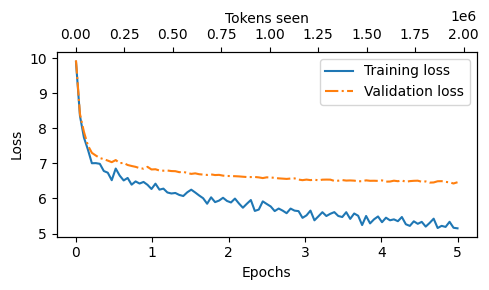

In [ ]:
from torch.utils.data import DataLoader

gpt2 = False  # custom tokenizer mode
tokenizer_v2 = SimpleTokenizerV2(vocab)  # regex tokenizer
vocab_size = len(tokenizer_v2.tokens2ids)

# === Config ===
GPT_CONFIG = {
    "vocab_size": vocab_size,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.3,
    "qkv_bias": False,
}

# === Dataset ===
train_ratio = 0.9
split = int(train_ratio * len(clean_text))
train_data, val_data = clean_text[:split], clean_text[split:]

train_loader = create_dataloader_v1(train_data, batch_size=2, max_length=GPT_CONFIG["context_length"], stride=GPT_CONFIG["context_length"], tokenizer=tokenizer_v2)
val_loader   = create_dataloader_v1(val_data,   batch_size=2, max_length=GPT_CONFIG["context_length"], stride=GPT_CONFIG["context_length"], shuffle=False, tokenizer=tokenizer_v2)

# === Model + training ===
model_regex = GPTModel(GPT_CONFIG).to(device)
optimizer = torch.optim.AdamW(model_regex.parameters(), lr=1e-4, weight_decay=0.1)

train_losses, val_losses, tokens_seen = train_model_simple(
    model_regex, train_loader, val_loader, optimizer, device,
    num_epochs=5, eval_freq=10, eval_iter=20,
    start_context="large language models are", tokenizer=tokenizer_v2)

torch.save(model_regex.state_dict(), "models/regex_pretrained.pth")
epochs_tensor = torch.linspace(0, 5, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Step 6: Pretrain GPT model using the GPT-2 tokenizer
Repeat the same pretraining pipeline, this time with the GPT-2 vocabulary and tokenizer.

Ep 1 (Step 000000): Train loss 10.659, Val loss 10.711
Ep 1 (Step 000010): Train loss 9.135, Val loss 9.193
Ep 1 (Step 000020): Train loss 8.563, Val loss 8.474
Ep 1 (Step 000030): Train loss 7.811, Val loss 7.942
Ep 1 (Step 000040): Train loss 7.533, Val loss 7.632
Ep 1 (Step 000050): Train loss 7.393, Val loss 7.482
Ep 1 (Step 000060): Train loss 7.103, Val loss 7.363
Ep 1 (Step 000070): Train loss 6.914, Val loss 7.286
Ep 1 (Step 000080): Train loss 6.916, Val loss 7.201
Ep 1 (Step 000090): Train loss 6.862, Val loss 7.148
Ep 1 (Step 000100): Train loss 6.875, Val loss 7.135
Ep 1 (Step 000110): Train loss 6.879, Val loss 7.052
Ep 1 (Step 000120): Train loss 6.499, Val loss 7.003
Ep 1 (Step 000130): Train loss 6.682, Val loss 6.985
Ep 1 (Step 000140): Train loss 6.513, Val loss 6.933
Ep 1 (Step 000150): Train loss 6.297, Val loss 6.890
Ep 1 (Step 000160): Train loss 6.559, Val loss 6.839
Ep 1 (Step 000170): Train loss 6.435, Val loss 6.816
Ep 1 (Step 000180): Train loss 6.380, Val lo

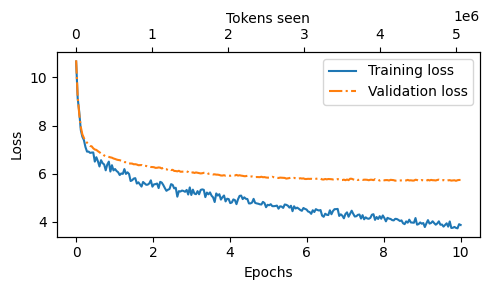

In [27]:
gpt2 = True
tokenizer_gpt2 = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer_gpt2.n_vocab
GPT_CONFIG["vocab_size"] = vocab_size

# Recreate model & loaders (same data)
train_loader = create_dataloader_v1(train_data, batch_size=2, max_length=GPT_CONFIG["context_length"], stride=GPT_CONFIG["context_length"], tokenizer=tokenizer_gpt2)
val_loader   = create_dataloader_v1(val_data,   batch_size=2, max_length=GPT_CONFIG["context_length"], stride=GPT_CONFIG["context_length"], shuffle=False, tokenizer=tokenizer_gpt2)

model_gpt2 = GPTModel(GPT_CONFIG).to(device)
optimizer = torch.optim.AdamW(model_gpt2.parameters(), lr=1e-4, weight_decay=0.1)

train_losses_gpt2, val_losses_gpt2, tokens_seen_gpt2 = train_model_simple(
    model_gpt2, train_loader, val_loader, optimizer, device,
    num_epochs=10, eval_freq=10, eval_iter=20,
    start_context="large language models are", tokenizer=tokenizer_gpt2)

torch.save(model_gpt2.state_dict(), "models/gpt2_pretrained.pth")
epochs_tensor = torch.linspace(0, 10, len(train_losses_gpt2))
plot_losses(epochs_tensor, tokens_seen_gpt2, train_losses_gpt2, val_losses_gpt2)

### Step 7: Load the pretrained Regex and GPT-2 models from saved checkpoints

This step restores the previously trained models (`gpt2_pretrained.pth` and `regex_pretrained.pth`) so they can be used later.

In [9]:
GPT_CONFIG = {
    "vocab_size": 1000,  # placeholder, will be updated
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.3,
    "qkv_bias": False}

# ---- Load Regex tokenizer model ----
gpt2 = False
tokenizer_v2 = SimpleTokenizerV2(vocab)
vocab_size = len(tokenizer_v2.tokens2ids)
GPT_CONFIG["vocab_size"] = vocab_size

model_regex = GPTModel(GPT_CONFIG).to(device)
model_regex.load_state_dict(torch.load("models/regex_pretrained.pth", map_location=device))
model_regex.eval()
print("🟦 Regex tokenizer model loaded.")

# ---- Load GPT-2 tokenizer model ----
gpt2 = True
tokenizer_gpt2 = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer_gpt2.n_vocab
GPT_CONFIG["vocab_size"] = vocab_size

model_gpt2 = GPTModel(GPT_CONFIG).to(device)
model_gpt2.load_state_dict(torch.load("models/gpt2_pretrained.pth", map_location=device))
model_gpt2.eval()
print("🟨 GPT-2 tokenizer model loaded.")

🟦 Regex tokenizer model loaded.
🟨 GPT-2 tokenizer model loaded.


### Step 8: Generate sample text using both trained models (Regex & GPT-2)

Here we use the same `generate()` function to compare how both models (regex-tokenizer and GPT-2 tokenizer) generate text.  
 - Adjust `top_k` and `temperature` for creativity control.

In [10]:
torch.manual_seed(123)
start_text = "large language models are"

# === Regex tokenizer model ===
gpt2 = False
vocab_size = len(tokenizer_v2.tokens2ids)
GPT_CONFIG["vocab_size"] = vocab_size
token_ids = generate(
    model=model_regex,
    idx=text_to_token_ids(start_text, tokenizer_v2).to(device),
    max_new_tokens=50,
    context_size=GPT_CONFIG["context_length"],
    top_k=25,
    temperature=1.4)
print("🟦 Regex tokenizer model output:\n", token_ids_to_text(token_ids, tokenizer_v2))

# === GPT-2 tokenizer model ===
gpt2 = True
vocab_size = tokenizer_gpt2.n_vocab
GPT_CONFIG["vocab_size"] = vocab_size
token_ids = generate(
    model=model_gpt2,
    idx=text_to_token_ids(start_text, tokenizer_gpt2).to(device),
    max_new_tokens=50,
    context_size=GPT_CONFIG["context_length"],
    top_k=25,
    temperature=1.4)
print("\n🟨 GPT-2 tokenizer model output:\n", token_ids_to_text(token_ids, tokenizer_gpt2))

🟦 Regex tokenizer model output:
 large language models are reported in a small, and training of large language models have been expected for all results were crucial and reasoning in the model in Figure 2. • We report a single dataset. We have significantly that is an efficient data that are presented in an internal the

🟨 GPT-2 tokenizer model output:
 large language models are the performance of the original previous work, where it has been significantly better than 2-attention-3 achieves strong results on the models with a large margin, and human written, GPT-3 demonstrates that of two tasks like GPT-2


## Part 2: Instruction–Response Pair Generation

Here we automates the creation of an instruction-following dataset.

### Step 1: Split Documents text into Subsections 

 - Prepare Source Documents: We split firstly the text into document units.
 - The cleaned text already uses (`=` * 80) as a delimiter.  

Each document may contain multiple paragraphs or sections, and using only full documents limits the number of possible instruction–response pairs.  

The `split_into_subsections()` function increases dataset richness by dividing each document into smaller **subsections** based on the following criteria:

- **Splitting rule:** It separates text wherever there is **one or more newline characters (`\n`)**.  
- **Filtering rule:** It keeps only those subsections containing **at least 80 words** (`min_words=80`) to ensure that each segment is substantial enough.

In [11]:
def split_into_subsections(docs, min_words=80): 
    # Previous configuration: min_words=117 was choosen manually to have = 2028 pairs
    # New configuration: min_words=80 to have more sections for training = 4840 pairs
    sections = []
    for d in docs:
        parts = re.split(r'\n{1,}', d)
        for p in parts:
            if len(p.split()) >= min_words:
                sections.append(p.strip())
    return sections

docs = [d.strip() for d in clean_text.split("=" * 80) if d.strip()]
print(f"Detected {len(docs)} documents.")

sections = split_into_subsections(docs)
print(f"Total sections: {len(sections)}")

Detected 37 documents.
Total sections: 1618


### Step 2: Loads a pretrained instruction-tuned model
   - Uses the free and open-source **`Qwen/Qwen2.5-7B-Instruct`** model from Hugging Face.  
   - Automatically initializes a text-generation pipeline.

In [12]:
import re, random, json
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# ===== Load Mistral-7B-Instruct model =====
# model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_name = "Qwen/Qwen2.5-7B-Instruct"
device = "cuda:2" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # prevent padding warnings
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to("cuda:2")

generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=2,  # explicitly pick cuda:2
    torch_dtype=torch.float16,
    max_new_tokens=256,
    temperature=0.7,
    top_p=0.9,
    batch_size=12)

Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu126 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cuda:2


### Step 3: Creates multiple types of instruction–input pairs per paragraph
  - Each paragraph is lightly cleaned and truncated to stay within the **1024-token context window**.
  - For each text chunk, three types of tasks are created:
     - **Summarization** — e.g., “Summarize the following passage in 1–3 sentences.”
     - **Explanation** — e.g., “Explain the main mechanism or method described.”
     - **Q&A** — e.g., “What is [Key Term] in this context?” (automatically picks a capitalized term from the text).
   - Each instruction and paragraph are wrapped in **Alpaca-style format**:
     ```
     Below is an instruction that describes a task. Write a response that appropriately completes the request.

     ### Instruction:
     [Instruction text]

     ### Input:
     [Paragraph text]

     ### Response:
     ```

### Step 4: Generates real model responses automatically
   - The Mistral model reads each formatted prompt and writes an appropriate answer.  
   - The generated response is extracted from the output and stored as `"Response"`.

### Step 5: Assembles and saves a full JSON dataset
   - The result is a list of dictionaries:
     ```json
     {
       "Instruction": "...",
       "Input": "...",
       "Response": "..."
     }
     ```
   - Saved to `instruction_data_from_pdfs.json`, ready for supervised fine-tuning.

In [ ]:
# ===== Generate instruction–response pairs =====
def make_pairs_from_paragraphs(paragraphs, target=2000, seed=123, max_chars=1500):
    random.seed(seed)
    random.shuffle(paragraphs)

    pairs = []
    progress = tqdm(total=target, desc="Generating instruction–response pairs")

    for p in paragraphs:
        text = re.sub(r"\s+", " ", p).strip()
        if len(text.split()) < 40:
            continue

        short_text = text[:max_chars]

        # Define 3 instruction types
        tasks = [
            ("Summarize the following passage in 1–3 sentences.", short_text),
            ("Explain the main mechanism or method described.", short_text)
        ]

        # Try to create a context-specific Q&A
        tokens = re.findall(r"[A-Za-z][A-Za-z\-]+", text)
        topic = next((t for t in tokens if t[0].isupper() and len(t) > 3), None)
        if topic:
            tasks.append((f"What is {topic} in this context?", short_text))

        # Batch prompts for efficiency
        prompts = [
            f"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n"
            f"### Instruction:\n{inst}\n\n### Input:\n{inp}\n\n### Response:\n"
            for inst, inp in tasks
        ]

        outputs = generator(prompts)

        for prompt, out in zip(prompts, outputs):
            response = out[0]["generated_text"].split("### Response:")[-1].strip()
            instruction = re.search(r"### Instruction:\n(.*?)\n\n### Input:", prompt, re.S).group(1)
            input_text = re.search(r"### Input:\n(.*)\n\n### Response:", prompt, re.S).group(1)

            pairs.append({
                "Instruction": instruction,
                "Input": input_text,
                "Response": response
            })

            progress.update(1)
            if len(pairs) >= target:
                progress.close()
                return pairs[:target]

    progress.close()
    return pairs[:target]

# debug_subset = sections[:15]  # use only first 15 sections
# pairs = make_pairs_from_paragraphs(debug_subset, target=10)

target0 = 4860 
# In a previous configuration, I set min_words=117 to get exactly 2028 pairs. 
# Now with min_words=80, I can get 4860 pairs.

pairs = make_pairs_from_paragraphs(sections, target=target0)
print(f"Generated {len(pairs)} instruction–response pairs.")

# ===== Save =====
with open("responces/instruction_data_from_pdfs.json", "w", encoding="utf-8") as f:
    json.dump(pairs, f, ensure_ascii=False, indent=2)
print("Saved → responces/instruction_data_from_pdfs.json")

Generating instruction–response pairs: 100%|█████████▉| 4840/4860 [3:20:16<00:49,  2.48s/it]  

Generated 4840 instruction–response pairs.
Saved → data\instruction_data_from_pdfs.json


### Step 6: Load the instruction dataset.

In [ ]:
import json
with open("responces/instruction_data_from_pdfs.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print(f"Loaded {len(data)} instruction–response pairs.")

Loaded 4840 instruction–response pairs.


### Step 7: Performs a Train/Validation split
   - Randomly shuffles and splits the dataset into:
     - *4340 training samples*
     - *500 validation samples*
  - In a previous configuration, I made *1528 training samples* and *500 validation samples*, and the performance was less compared to this new configuration.

In [15]:
pairs = data.copy()
random.shuffle(pairs)
val_set = pairs[:500]
train_set = pairs[500:]

print(f"train: {len(train_set)} | val: {len(val_set)} | total: {len(pairs)}")

train: 4340 | val: 500 | total: 4840


## Part 3 — Fine-Tuning The Pretrained Models
Here we fine-tune both pretrained models (Regex and GPT-2 versions) on the generated instruction dataset.

### Step 1: Prepare datasets and dataloaders

- `InstructionDataset()` and `format_input()` are used to prepare the dataset for instruction fine-tuning.  
    - They convert each JSON entry (with keys `"Instruction"`, `"Input"`, and `"Response"`) into an **Alpaca-style prompt–response format** suitable for LLM models.
    - **`format_input()`:** Formats each record into the Alpaca-style text.
    - **`InstructionDataset()`:** loads the pre-generated *Instruction–Input–Response* triplets and tokenizes them into input–target pairs.

- We use **`custom_collate_fn()`** to pad and align input–target sequences within each batch.  
    - Padding tokens (`<|endoftext|>`) are ignored in the loss function using `ignore_index = -100`.

In [16]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['Response']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['Instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['Input']}" if entry["Input"] else ""
    return instruction_text + input_text

def custom_collate_fn(batch, pad_token_id, ignore_index=-100, allowed_max_length=None, device="cpu"):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item)))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [17]:
from torch.utils.data import DataLoader
from functools import partial

# === Regex tokenizer model ===
regex_pad_token = "<|endoftext|>" # "<|endoftext|>" is the second last token.
regex_pad_id = tokenizer_v2.tokens2ids.get(regex_pad_token, len(tokenizer_v2.tokens2ids) - 1)
customized_collate_regex = partial(custom_collate_fn, pad_token_id=regex_pad_id, device=device, allowed_max_length=1024)

train_dataset_regex = InstructionDataset(train_set, tokenizer_v2)
val_dataset_regex = InstructionDataset(val_set, tokenizer_v2)

train_loader_regex = DataLoader(train_dataset_regex, batch_size=8, collate_fn=customized_collate_regex, shuffle=True)
val_loader_regex = DataLoader(val_dataset_regex, batch_size=8, collate_fn=customized_collate_regex, shuffle=False)
print("🟦 Regex loaders ready.")

# === GPT-2 tokenizer model ===
gpt2_pad_id = 50256  # <|endoftext|> in GPT-2
customized_collate_gpt2 = partial(custom_collate_fn, pad_token_id=gpt2_pad_id, device=device, allowed_max_length=1024)

train_dataset_gpt2 = InstructionDataset(train_set, tokenizer_gpt2)
val_dataset_gpt2 = InstructionDataset(val_set, tokenizer_gpt2)

train_loader_gpt2 = DataLoader(train_dataset_gpt2, batch_size=8, collate_fn=customized_collate_gpt2, shuffle=True)
val_loader_gpt2 = DataLoader(val_dataset_gpt2, batch_size=8, collate_fn=customized_collate_gpt2, shuffle=False)
print("🟨 GPT-2 loaders ready.")

🟦 Regex loaders ready.
🟨 GPT-2 loaders ready.


### Step 2: Fine-Tuning the Regex Model

- Saves the fine-tuned checkpoint as **`regex_finetuned.pth`**.  
- Plots both **training** and **validation loss curves** across epochs.  

Ep 1 (Step 000000): Train loss 5.863, Val loss 5.848
Ep 1 (Step 000050): Train loss 4.960, Val loss 5.017
Ep 1 (Step 000100): Train loss 4.873, Val loss 4.871
Ep 1 (Step 000150): Train loss 4.776, Val loss 4.811
Ep 1 (Step 000200): Train loss 4.694, Val loss 4.775
Ep 1 (Step 000250): Train loss 4.638, Val loss 4.727
Ep 1 (Step 000300): Train loss 4.671, Val loss 4.697
Ep 1 (Step 000350): Train loss 4.629, Val loss 4.673
Ep 1 (Step 000400): Train loss 4.551, Val loss 4.633
Ep 1 (Step 000450): Train loss 4.520, Val loss 4.611
Ep 1 (Step 000500): Train loss 4.548, Val loss 4.591
Below is an instruction that describes a task. Write a response that appropriately completes the request. ### Instruction : Summarize the following passage in <|unk|> sentences. ### Input : We show downstream results of differently-sized models in Table 15 in the Appendix. Downstream metrics suggest that the optimal number of parameters for a 1 × 1022 FLOPs model is in fact around 9. 5B, in close agreement with th

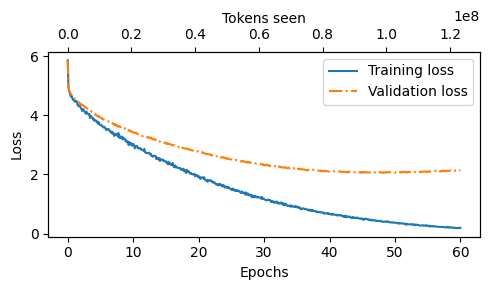

In [39]:
import torch.optim as optim
torch.cuda.empty_cache()

gpt2 = False
model_regex = model_regex.to(device)
model_regex.train()

optimizer_regex = torch.optim.AdamW(model_regex.parameters(), lr=5e-5, weight_decay=0.1)

torch.manual_seed(123)
train_losses_rx, val_losses_rx, tokens_rx = train_model_simple(
    model_regex, train_loader_regex, val_loader_regex, optimizer_regex, device,
    num_epochs=60, eval_freq=50, eval_iter=20,
    start_context=format_input(val_set[0]), tokenizer=tokenizer_v2)

torch.save(model_regex.state_dict(), "models/regex_finetuned.pth")
print("🟦 saved → models/regex_finetuned.pth")

epochs_tensor = torch.linspace(0, 60, len(train_losses_rx))
plot_losses(epochs_tensor, tokens_rx, train_losses_rx, val_losses_rx)

### Step 3: Fine-Tuning the GPT-2 Model

- Saves the fine-tuned checkpoint as **`gpt2_finetuned.pth`**.  
- Plots both **training** and **validation loss curves** across epochs.  

Ep 1 (Step 000000): Train loss 5.339, Val loss 5.312
Ep 1 (Step 000050): Train loss 4.353, Val loss 4.392
Ep 1 (Step 000100): Train loss 4.293, Val loss 4.267
Ep 1 (Step 000150): Train loss 4.149, Val loss 4.209
Ep 1 (Step 000200): Train loss 4.150, Val loss 4.187
Ep 1 (Step 000250): Train loss 3.987, Val loss 4.134
Ep 1 (Step 000300): Train loss 4.191, Val loss 4.116
Ep 1 (Step 000350): Train loss 4.024, Val loss 4.087
Ep 1 (Step 000400): Train loss 3.953, Val loss 4.038
Ep 1 (Step 000450): Train loss 3.910, Val loss 4.049
Ep 1 (Step 000500): Train loss 3.956, Val loss 4.014
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Summarize the following passage in 1–3 sentences.  ### Input: We show downstream results of differently-sized models in Table 15 in the Appendix. Downstream metrics suggest that the optimal number of parameters for a 1 × 1022 FLOPs model is in fact around 9.5B, in close agreement with the tra

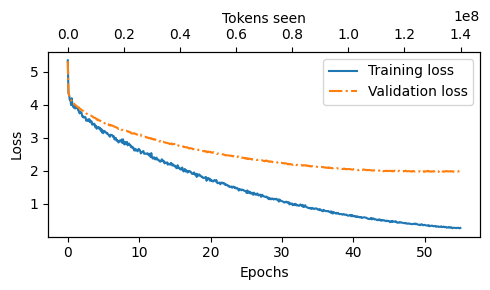

In [40]:
torch.cuda.empty_cache()
gpt2 = True
model_gpt2 = model_gpt2.to(device)
model_gpt2.train()

optimizer_gpt2 = torch.optim.AdamW(model_gpt2.parameters(), lr=5e-5, weight_decay=0.1)

torch.manual_seed(123)
train_losses_g2, val_losses_g2, tokens_g2 = train_model_simple(
    model_gpt2, train_loader_gpt2, val_loader_gpt2, optimizer_gpt2, device,
    num_epochs=55, eval_freq=50, eval_iter=20,
    start_context=format_input(val_set[0]), tokenizer=tokenizer_gpt2)

torch.save(model_gpt2.state_dict(), "models/gpt2_finetuned.pth")
print("🟨 saved → models/gpt2_finetuned.pth")

epochs_tensor = torch.linspace(0, 55, len(train_losses_g2))
plot_losses(epochs_tensor, tokens_g2, train_losses_g2, val_losses_g2)

### Step 4: Load the fine-tuned Regex and GPT-2 models from saved checkpoints

This step restores the previously trained models (`regex_finetuned.pth` and `gpt2_finetuned.pth`) so they can be used later.

In [18]:
GPT_CONFIG = {
    "vocab_size": 1000,  # placeholder, will be updated
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.3,
    "qkv_bias": False}

# === Load fine-tuned Regex model ===
gpt2 = False
tokenizer_v2 = SimpleTokenizerV2(vocab)
vocab_size = len(tokenizer_v2.tokens2ids)
GPT_CONFIG["vocab_size"] = vocab_size

model_regex = GPTModel(GPT_CONFIG).to(device)
model_regex.load_state_dict(torch.load("models/regex_finetuned.pth", map_location=device))
model_regex.eval()
print("🟦 Regex finetuned model loaded.")

# === Load fine-tuned GPT-2 model ===
gpt2 = True
tokenizer_gpt2 = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer_gpt2.n_vocab
GPT_CONFIG["vocab_size"] = vocab_size

model_gpt2 = GPTModel(GPT_CONFIG).to(device)
model_gpt2.load_state_dict(torch.load("models/gpt2_finetuned.pth", map_location=device))
model_gpt2.eval()
print("🟨 GPT-2 finetuned model loaded.")

🟦 Regex finetuned model loaded.
🟨 GPT-2 finetuned model loaded.


### Step 5: Generating Model Responses on the Validation Set

- The function `generate_text()` uses the helper `generate_text_simple()` to autoregressively predict the next tokens up to `max_new_tokens = 256`.
- Each prompt follows the **Alpaca-style format**, combining:
  - `### Instruction:` (task description)
  - `### Input:` (optional contextual passage)
  - `### Response:` (expected model output)
- Each generated response is stored under the key `"model_response"` for later evaluation.
- The resulting subset is saved as **`gpt2_val_responses.json`**.

This step effectively simulates how the fine-tuned model would respond to unseen instructions.

In [19]:
def generate_text(model, tokenizer, prompt, max_new_tokens=256):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(prompt, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(model=model, idx=encoded, max_new_tokens=max_new_tokens, context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    return decoded_text[len(prompt):].replace("### Response:", "").strip()

In [ ]:
# debug_subset = val_set[:15] # use only first 15 entries for quick testing.

# === Generate Regex model responses ===
gpt2 = False
for i, entry in tqdm(enumerate(val_set), total=len(val_set), desc="Generating models responses"):
    alpaca_prompt = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['Instruction']}")
    if entry['Input']:
        alpaca_prompt += f"\n\n### Input:\n{entry['Input']}"
    alpaca_prompt += "\n\n### Response:\n"

    entry["model_response"] = generate_text(model_regex, tokenizer_v2, alpaca_prompt)

with open("responces/regex_val_responses.json", "w", encoding="utf-8") as f:
    json.dump(val_set, f, indent=2, ensure_ascii=False)
print("🟦 Saved Regex model responses → responces/regex_val_responses.json")


# === Generate GPT-2 model responses ===
gpt2 = True
for i, entry in tqdm(enumerate(val_set), total=len(val_set), desc="Generating models responses"):
    alpaca_prompt = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['Instruction']}")
    if entry['Input']:
        alpaca_prompt += f"\n\n### Input:\n{entry['Input']}"
    alpaca_prompt += "\n\n### Response:\n"

    entry["model_response"] = generate_text(model_gpt2, tokenizer_gpt2, alpaca_prompt)

with open("responces/gpt2_val_responses.json", "w", encoding="utf-8") as f:
    json.dump(val_set, f, indent=2, ensure_ascii=False)
print("🟨 Saved GPT-2 model responses → responces/gpt2_val_responses.json")

Generating models responses: 100%|██████████| 500/500 [16:54<00:00,  2.03s/it]


🟦 Saved Regex model responses → data/regex_val_responses.json


Generating models responses: 100%|██████████| 500/500 [24:43<00:00,  2.97s/it]

🟨 Saved GPT-2 model responses → data/gpt2_val_responses.json


### Step 6: Loading Saved Model Response Validation Files

Here we load the JSON files containing the generated validation responses from both fine-tuned models:

- **Regex Model:** `Regex_val_responses.json`
- **GPT-2 Model:** `gpt2_val_responses.json`

In [ ]:
# Load Regex model responses
with open("responces/regex_val_responses.json", "r", encoding="utf-8") as f:
    regex_val_responses = json.load(f)
print(f"🟦 Loaded {len(regex_val_responses)} Regex val responses.")

# Load GPT-2 model responses
with open("responces/gpt2_val_responses.json", "r", encoding="utf-8") as f:
    gpt2_val_responses = json.load(f)
print(f"🟨 Loaded {len(gpt2_val_responses)} GPT-2 val responses.")

🟦 Loaded 500 Regex val responses.
🟨 Loaded 500 GPT-2 val responses.


## Part 4 — Evaluation on the Validation Set

We evaluate the fine-tuned models using:
1.  **Automatic scoring (Quantitatively):** Using **BLEU-4**, **ROUGE-1/2/L-F1**, **METEOR**, **Token-F1**, and **BERTScore** metrics.
2.  **LLM-based evaluation (Qualitatively):** Using an LLM model (**`Phi-3-mini-4k-instruct`**) as a judge to grade responses from 0–100.

This helps quantify how well the model follows instructions compared to ground-truth responses.

### Step 1: Automatic scoring (Quantitatively).
- Using **BLEU-4**, **ROUGE-1/2/L-F1**, **METEOR**, **Token-F1**, and **BERTScore** metrics.

In [21]:
from typing import List, Dict, Tuple, Optional
import re, random
from collections import Counter
import numpy as np
import sacrebleu
from rouge_score import rouge_scorer
import nltk
from nltk.translate.meteor_score import meteor_score as nltk_meteor_score
from bert_score import score as bertscore_score

# -------- Utilities --------
def _flat(s: Optional[str]) -> str:
    return (s or "").strip()

def _normalize(s: str) -> str:
    return re.sub(r"\s+", " ", s.lower().strip())

def _fmt(x, nd=3):
    try: return f"{float(x):.{nd}f}"
    except Exception: return "n/a"

# -------- Metrics ----------
def compute_bleu(hyps: List[str], refs: List[str]) -> Dict:
    bleu = sacrebleu.corpus_bleu(hyps, [refs])
    return {
        "BLEU-4": float(bleu.score),
        "P1": float(bleu.precisions[0]),
        "P2": float(bleu.precisions[1]),
        "P3": float(bleu.precisions[2]),
        "P4": float(bleu.precisions[3]),
        "BP": float(bleu.bp),
        "sys_len": int(bleu.sys_len),
        "ref_len": int(bleu.ref_len),
    }

def compute_rouge(hyps: List[str], refs: List[str]) -> Dict:
    scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)
    r1 = r2 = rl = 0.0
    for h, r in zip(hyps, refs):
        s = scorer.score(r, h)
        r1 += s["rouge1"].fmeasure; r2 += s["rouge2"].fmeasure; rl += s["rougeL"].fmeasure
    n = max(1, len(hyps))
    return {"ROUGE-1-F1": r1/n, "ROUGE-2-F1": r2/n, "ROUGE-L-F1": rl/n}

def compute_meteor(hyps: List[str], refs: List[str]) -> Dict:
    for pkg in ["corpora/wordnet", "corpora/omw-1.4"]:
        try: nltk.data.find(pkg)
        except LookupError: nltk.download(pkg.split("/")[1], quiet=True)
    scores = [nltk_meteor_score([_flat(r).split()], _flat(h).split())
              for h, r in zip(hyps, refs) if _flat(h) and _flat(r)]
    return {"METEOR": float(sum(scores)/len(scores)) if scores else 0.0, "used": len(scores)}

def compute_token_f1(hyps: List[str], refs: List[str]) -> Dict:
    tp=fp=fn=0
    for h, r in zip(hyps, refs):
        ch, cr = Counter(_flat(h).split()), Counter(_flat(r).split())
        common = ch & cr
        tp += sum(common.values()); fp += sum((ch - cr).values()); fn += sum((cr - ch).values())
    prec = tp/(tp+fp) if tp+fp else 0.0
    rec  = tp/(tp+fn) if tp+fn else 0.0
    f1   = 2*prec*rec/(prec+rec) if prec+rec else 0.0
    return {"precision": prec, "recall": rec, "F1": f1}

def compute_bertscore(hyps: List[str], refs: List[str]) -> Dict:
    P,R,F1 = bertscore_score(hyps, refs, lang="en",
                             model_type="roberta-large",
                             rescale_with_baseline=True)
    return {"P": float(P.mean()), "R": float(R.mean()), "F1": float(F1.mean()),
            "model_type": "roberta-large", "baseline_rescale": True}

def compute_all_metrics(hyps: List[str], refs: List[str]) -> Dict:
    return {
        "BLEU": compute_bleu(hyps, refs),
        "ROUGE": compute_rouge(hyps, refs),
        "METEOR": compute_meteor(hyps, refs),
        "TokenF1": compute_token_f1(hyps, refs),
        "BERTScore": compute_bertscore(hyps, refs),
        "count": len(hyps)
    }

# -------- Helpers --------
def _pick(d: dict, keys: List[str]) -> Optional[str]:
    for k in keys:
        if k in d and d[k] is not None:
            return str(d[k])
    return None

def _extract_pairs(dataset: List[dict],
                   pred_keys=("model_response","prediction","output","hypothesis","hyp"),
                   ref_keys=("Response","response","reference","ref","target","gold"),
                   normalize_text: bool=False) -> Tuple[List[str], List[str]]:
    hyps, refs = [], []
    for ex in dataset:
        h = _pick(ex, pred_keys) or ""
        r = _pick(ex, ref_keys) or ""
        if normalize_text: h, r = _normalize(h), _normalize(r)
        hyps.append(h); refs.append(r)
    return hyps, refs

# -------- Output --------
def _print_metrics_table(model_name: str, M: Dict):
    print(f"\n=== {model_name} Quantitative Metrics ===")
    b = M["BLEU"]
    print(f"BLEU-4:    {_fmt(b['BLEU-4'],2)}  (BP={_fmt(b['BP'],2)}, P1={_fmt(b['P1'],2)}, P2={_fmt(b['P2'],2)}, P3={_fmt(b['P3'],2)}, P4={_fmt(b['P4'],2)})")
    r = M["ROUGE"]
    print(f"ROUGE-1/2/L-F1: {_fmt(r['ROUGE-1-F1'])} / {_fmt(r['ROUGE-2-F1'])} / {_fmt(r['ROUGE-L-F1'])}")
    m = M["METEOR"]
    print(f"METEOR:    {_fmt(m['METEOR'])} (used {m['used']})")
    tf1 = M["TokenF1"]; print(f"Token-F1:  {_fmt(tf1['F1'])} (P={_fmt(tf1['precision'])}, R={_fmt(tf1['recall'])})")
    bs = M["BERTScore"]
    print(f"BERTScore: {_fmt(bs['F1'])} (P={_fmt(bs['P'])}, R={_fmt(bs['R'])}, model={bs['model_type']}, baseline={bs['baseline_rescale']})")
    print(f"Count:     {M['count']}")

# -------- Main --------
def evaluate_model_outputs(model_name: str, dataset: List[dict], *, normalize_text=False, seed=1234) -> Dict:
    random.seed(seed); np.random.seed(seed)
    try:
        import torch; torch.manual_seed(seed)
    except Exception:
        pass
    hyps, refs = _extract_pairs(dataset, normalize_text=normalize_text)
    M = compute_all_metrics(hyps, refs)
    _print_metrics_table(model_name, M)
    return M

In [46]:
evaluate_model_outputs("Regex", regex_val_responses)
evaluate_model_outputs("GPT-2", gpt2_val_responses)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Regex Quantitative Metrics ===
BLEU-4:    4.99  (BP=1.00, P1=24.68, P2=7.71, P3=2.84, P4=1.14)
ROUGE-1/2/L-F1: 0.383 / 0.114 / 0.198
METEOR:    0.237 (used 500)
Token-F1:  0.299 (P=0.250, R=0.373)
BERTScore: -0.104 (P=-0.239, R=0.039, model=roberta-large, baseline=True)
Count:     500


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== GPT-2 Quantitative Metrics ===
BLEU-4:    9.18  (BP=1.00, P1=35.78, P2=12.66, P3=5.61, P4=2.79)
ROUGE-1/2/L-F1: 0.400 / 0.120 / 0.212
METEOR:    0.235 (used 500)
Token-F1:  0.324 (P=0.306, R=0.345)
BERTScore: 0.061 (P=0.009, R=0.115, model=roberta-large, baseline=True)
Count:     500


{'BLEU': {'BLEU-4': 9.180958802774926,
  'P1': 35.77764899924219,
  'P2': 12.66377110106121,
  'P3': 5.610578869248415,
  'P4': 2.794921610265215,
  'BP': 1.0,
  'sys_len': 112165,
  'ref_len': 92124},
 'ROUGE': {'ROUGE-1-F1': 0.3995022426567119,
  'ROUGE-2-F1': 0.11980240790786621,
  'ROUGE-L-F1': 0.21195809219572329},
 'METEOR': {'METEOR': 0.23484834823196452, 'used': 500},
 'TokenF1': {'precision': 0.30569031381096345,
  'recall': 0.34501593683458753,
  'F1': 0.3241647975445638},
 'BERTScore': {'P': 0.009061903692781925,
  'R': 0.11460093408823013,
  'F1': 0.060826919972896576,
  'model_type': 'roberta-large',
  'baseline_rescale': True},
 'count': 500}

### Step 2: LLM-based evaluation (Qualitatively):
- Using an LLM model (**`Qwen2.5-7B-Instruct`**) as a judge to grade responses from 0–100.

In [22]:

from typing import List, Optional
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

JUDGE_MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct" # or "microsoft/Phi-3-mini-4k-instruct"

# ---- Load judge (simple device/dtype selection) ----
torch_dtype = (torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
               else (torch.float16 if torch.cuda.is_available() else None))
tokenizer_judge = AutoTokenizer.from_pretrained(JUDGE_MODEL_NAME)
model_judge = AutoModelForCausalLM.from_pretrained(JUDGE_MODEL_NAME, torch_dtype=torch_dtype, device_map="auto")

judge_pipe = pipeline(
    "text-generation",
    model=model_judge,
    tokenizer=tokenizer_judge,
    batch_size=4,
    do_sample=False,
    temperature=1e-5,
    max_new_tokens=64,
    pad_token_id=tokenizer_judge.eos_token_id,
)

# ---- Prompt + score parsing ----
SYSTEM_RUBRIC = (
    "You are an expert grader. You will rate a candidate answer against a reference.\n"
    "Scoring: 0 to 100 (100 = perfect). Consider correctness, faithfulness to the reference, "
    "coverage/completeness, and clarity. IMPORTANT: Respond with ONLY the final integer score, "
    "no words, no punctuation, no explanations."
)

def make_prompt(instruction: str, inp: Optional[str], reference: str, hypothesis: str) -> str:
    return (
        f"{SYSTEM_RUBRIC}\n\n"
        f"Instruction:\n{(instruction or '').strip()}\n\n"
        f"Input:\n{(inp or '').strip()}\n\n"
        f"Reference answer:\n{(reference or '').strip()}\n\n"
        f"Model's answer:\n{(hypothesis or '').strip()}\n\n"
        "Final score (0-100):"
    )

_num_pat = re.compile(r"\b(\d{1,3})\b")
def parse_score(text: str) -> Optional[int]:
    m = _num_pat.findall(text or "")
    if not m: return None
    try:
        return max(0, min(100, int(m[-1])))
    except Exception:
        return None

# ---- Batch query ----
def query_judge_batch(prompts: List[str]) -> List[Optional[int]]:
    outs = judge_pipe(prompts)
    scores = []
    for o in outs:
        if isinstance(o, list): o = o[0]
        scores.append(parse_score(o.get("generated_text", "")))
    return scores

# ---- Evaluate one model ----
def evaluate_with_judge(model_name: str, dataset: List[dict], *, batch_size: int = 4, limit: Optional[int] = None, seed: int = 1234) -> dict:
    random.seed(seed)
    n = len(dataset) if limit is None else min(len(dataset), int(limit))
    prompts = [
        make_prompt(ex.get("Instruction",""), ex.get("Input",""), ex.get("Response",""), ex.get("model_response",""))
        for ex in dataset[:n]
    ]

    scores: List[int] = []
    for i in tqdm(range(0, len(prompts), batch_size), desc=f"Judge Scoring ({model_name})"):
        batch_scores = query_judge_batch(prompts[i:i+batch_size])
        scores.extend(int(s) for s in batch_scores if isinstance(s, int))

    if scores:
        avg, mn, mx = sum(scores)/len(scores), min(scores), max(scores)
        print(f"\n[Judge] {model_name}: avg={avg:.1f}% | min={mn} | max={mx} | n={len(scores)}\n")
        return {"model": model_name, "avg": avg, "min": mn, "max": mx, "n": len(scores), "scores": scores}
    else:
        print(f"\n[Judge] {model_name}: no valid scores parsed.\n")
        return {"model": model_name, "avg": None, "min": None, "max": None, "n": 0, "scores": []}

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [51]:
evaluate_with_judge("Regex", regex_val_responses, batch_size=4)
evaluate_with_judge("GPT-2", gpt2_val_responses,  batch_size=4)

Judge Scoring (Regex): 100%|██████████| 125/125 [07:37<00:00,  3.66s/it]



[Judge] Regex: avg=43.3% | min=0 | max=100 | n=500



Judge Scoring (GPT-2): 100%|██████████| 125/125 [07:31<00:00,  3.61s/it]


[Judge] GPT-2: avg=49.9% | min=0 | max=100 | n=500



{'model': 'GPT-2',
 'avg': 49.932,
 'min': 0,
 'max': 100,
 'n': 500,
 'scores': [72,
  65,
  65,
  25,
  35,
  85,
  55,
  100,
  65,
  72,
  4,
  4,
  65,
  65,
  100,
  65,
  100,
  55,
  58,
  25,
  0,
  72,
  25,
  63,
  4,
  65,
  58,
  3,
  42,
  58,
  65,
  25,
  55,
  65,
  65,
  25,
  2,
  100,
  3,
  65,
  85,
  100,
  65,
  55,
  4,
  58,
  4,
  72,
  65,
  55,
  15,
  58,
  100,
  58,
  72,
  5,
  72,
  42,
  25,
  15,
  3,
  100,
  25,
  25,
  100,
  35,
  75,
  65,
  85,
  50,
  100,
  42,
  65,
  42,
  50,
  25,
  25,
  95,
  35,
  3,
  72,
  65,
  52,
  3,
  65,
  25,
  75,
  0,
  3,
  62,
  65,
  35,
  65,
  65,
  52,
  15,
  52,
  65,
  35,
  1,
  58,
  62,
  1,
  55,
  65,
  32,
  65,
  55,
  65,
  78,
  52,
  67,
  85,
  1,
  15,
  2,
  55,
  85,
  5,
  75,
  55,
  42,
  0,
  58,
  65,
  58,
  65,
  65,
  55,
  65,
  65,
  42,
  72,
  75,
  2,
  55,
  65,
  55,
  100,
  67,
  65,
  65,
  55,
  65,
  25,
  20,
  1,
  75,
  25,
  50,
  100,
  58,
  75,
  72,
  65,
  

## Part 5 - Using GPT-2 Pretrained Weights to Compare with Our Regex and GPT-2 Models


In this part, we use the **GPT-2 (small, 124M parameters)** pretrained weights to establish a stronger baseline and compare against our Regex and GPT-2 models.

**Steps:**
1. **Download** the pretrained GPT-2o model weights (`gpt2-small (124M)`) and load it.
2. **Fine-tune** the model on our custom **instruction dataset**.
3. **Generate** validation responses using the fine-tuned GPT-2o model.

In [23]:
import urllib.request
# import tensorflow
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch05/01_main-chapter-code/gpt_download.py") 
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [24]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"
gpt2 = True
NEW_CONFIG = GPT_CONFIG.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt2o = GPTModel(NEW_CONFIG)

In [25]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt2o, params):
    """Load GPT-2o weights from a params dict into a PyTorch GPT model."""

    # --- Embeddings ---
    gpt2o.pos_emb.weight = assign(gpt2o.pos_emb.weight, params["wpe"])
    gpt2o.tok_emb.weight = assign(gpt2o.tok_emb.weight, params["wte"])

    # --- Transformer Blocks ---
    num_blocks = len(params["blocks"])
    for b in range(num_blocks):
        block = params["blocks"][b]

        # === Attention Projections ===
        # Split qkv weights
        q_w, k_w, v_w = np.split(block["attn"]["c_attn"]["w"], 3, axis=-1)
        q_b, k_b, v_b = np.split(block["attn"]["c_attn"]["b"], 3, axis=-1)

        gpt2o.trf_blocks[b].att.W_query.weight = assign(
            gpt2o.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt2o.trf_blocks[b].att.W_key.weight = assign(
            gpt2o.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt2o.trf_blocks[b].att.W_value.weight = assign(
            gpt2o.trf_blocks[b].att.W_value.weight, v_w.T)

        gpt2o.trf_blocks[b].att.W_query.bias = assign(
            gpt2o.trf_blocks[b].att.W_query.bias, q_b)
        gpt2o.trf_blocks[b].att.W_key.bias = assign(
            gpt2o.trf_blocks[b].att.W_key.bias, k_b)
        gpt2o.trf_blocks[b].att.W_value.bias = assign(
            gpt2o.trf_blocks[b].att.W_value.bias, v_b)

        # Output projection
        gpt2o.trf_blocks[b].att.out_proj.weight = assign(
            gpt2o.trf_blocks[b].att.out_proj.weight, block["attn"]["c_proj"]["w"].T)
        gpt2o.trf_blocks[b].att.out_proj.bias = assign(
            gpt2o.trf_blocks[b].att.out_proj.bias, block["attn"]["c_proj"]["b"])

        # === MLP / Feed Forward ===
        gpt2o.trf_blocks[b].ff.layers[0].weight = assign(
            gpt2o.trf_blocks[b].ff.layers[0].weight, block["mlp"]["c_fc"]["w"].T)
        gpt2o.trf_blocks[b].ff.layers[0].bias = assign(
            gpt2o.trf_blocks[b].ff.layers[0].bias, block["mlp"]["c_fc"]["b"])

        gpt2o.trf_blocks[b].ff.layers[2].weight = assign(
            gpt2o.trf_blocks[b].ff.layers[2].weight, block["mlp"]["c_proj"]["w"].T)
        gpt2o.trf_blocks[b].ff.layers[2].bias = assign(
            gpt2o.trf_blocks[b].ff.layers[2].bias, block["mlp"]["c_proj"]["b"])

        # === LayerNorm Fix (PyTorch uses weight/bias, not scale/shift) ===
        gpt2o.trf_blocks[b].norm1.weight = assign(
            gpt2o.trf_blocks[b].norm1.weight, block["ln_1"]["g"])
        gpt2o.trf_blocks[b].norm1.bias = assign(
            gpt2o.trf_blocks[b].norm1.bias, block["ln_1"]["b"])

        gpt2o.trf_blocks[b].norm2.weight = assign(
            gpt2o.trf_blocks[b].norm2.weight, block["ln_2"]["g"])
        gpt2o.trf_blocks[b].norm2.bias = assign(
            gpt2o.trf_blocks[b].norm2.bias, block["ln_2"]["b"])

    # --- Final LayerNorm ---
    gpt2o.final_norm.weight = assign(gpt2o.final_norm.weight, params["g"])
    gpt2o.final_norm.bias = assign(gpt2o.final_norm.bias, params["b"])

    # --- Output head tied to embedding ---
    gpt2o.out_head.weight = assign(gpt2o.out_head.weight, params["wte"])
    
load_weights_into_gpt(gpt2o, params)
gpt2o.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.3, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (drop_shortcut): Dropout(p=0.3, inplace=False)
   

In [26]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt2o,
    idx=text_to_token_ids("large language models are", tokenizer_gpt2).to(device),
    max_new_tokens=50,
    context_size=NEW_CONFIG["context_length"],
    top_k=25,
    temperature=1.4
)
print("\n🟨 GPT-2o (Pretrained Weights) tokenizer model output:\n", token_ids_to_text(token_ids, tokenizer_gpt2))
print("\n🟨 GPT-2o loaders already ready.")


🟨 GPT-2o (Pretrained Weights) tokenizer model output:
 large language models are not very. of is more like a real; if a- what's the size to the different- is, as are are a really people on being around the people who are. being are the people. That (and are) a) the

🟨 GPT-2o loaders already ready.


Ep 1 (Step 000000): Train loss 3.277, Val loss 3.246
Ep 1 (Step 000050): Train loss 2.662, Val loss 2.654
Ep 1 (Step 000100): Train loss 2.549, Val loss 2.506
Ep 1 (Step 000150): Train loss 2.437, Val loss 2.431
Ep 1 (Step 000200): Train loss 2.403, Val loss 2.381
Ep 1 (Step 000250): Train loss 2.317, Val loss 2.348
Ep 1 (Step 000300): Train loss 2.350, Val loss 2.317
Ep 1 (Step 000350): Train loss 2.304, Val loss 2.296
Ep 1 (Step 000400): Train loss 2.236, Val loss 2.270
Ep 1 (Step 000450): Train loss 2.233, Val loss 2.253
Ep 1 (Step 000500): Train loss 2.247, Val loss 2.232
Below is an instruction that describes a task. Write a response that appropriately completes the request.  ### Instruction: Summarize the following passage in 1–3 sentences.  ### Input: We show downstream results of differently-sized models in Table 15 in the Appendix. Downstream metrics suggest that the optimal number of parameters for a 1 × 1022 FLOPs model is in fact around 9.5B, in close agreement with the tra

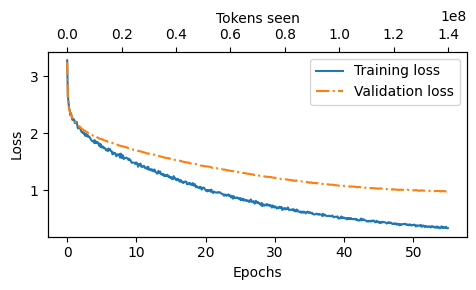

In [56]:
torch.cuda.empty_cache()
gpt2o = gpt2o.to(device)
gpt2o.train()

optimizer_gpt2o = torch.optim.AdamW(gpt2o.parameters(), lr=5e-5, weight_decay=0.1)

torch.manual_seed(123)
train_losses_g, val_losses_g, tokens_g = train_model_simple(
    gpt2o, train_loader_gpt2, val_loader_gpt2, optimizer_gpt2o, device,
    num_epochs=55, eval_freq=50, eval_iter=20,
    start_context=format_input(val_set[0]), tokenizer=tokenizer_gpt2)

torch.save(gpt2o.state_dict(), "models/gpt2o_finetuned.pth")
print("🟨 saved → models/gpt2o_finetuned.pth")

epochs_tensor = torch.linspace(0, 55, len(train_losses_g))
plot_losses(epochs_tensor, tokens_g, train_losses_g, val_losses_g)

In [27]:
# === Load fine-tuned GPT-2o model ===
gpt2 = True
tokenizer_gpt2 = tiktoken.get_encoding("gpt2")
vocab_size = tokenizer_gpt2.n_vocab
NEW_CONFIG["vocab_size"] = vocab_size

gpt2o = GPTModel(NEW_CONFIG).to(device)
gpt2o.load_state_dict(torch.load("models/gpt2o_finetuned.pth", map_location=device))
gpt2o.eval()
print("🟨 GPT-2o finetuned model loaded.")

🟨 GPT-2o finetuned model loaded.


In [ ]:
# === Generate GPT model responses ===
gpt2 = True
for i, entry in tqdm(enumerate(val_set), total=len(val_set), desc="Generating models responses"):
    alpaca_prompt = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['Instruction']}")
    if entry['Input']:
        alpaca_prompt += f"\n\n### Input:\n{entry['Input']}"
    alpaca_prompt += "\n\n### Response:\n"

    entry["model_response"] = generate_text(gpt2o, tokenizer_gpt2, alpaca_prompt)

with open("responces/gpt2o_val_responses.json", "w", encoding="utf-8") as f:
    json.dump(val_set, f, indent=2, ensure_ascii=False)
print("🟨 Saved GPT-2o model responses → responces/gpt2o_val_responses.json")

Generating models responses: 100%|██████████| 500/500 [30:06<00:00,  3.61s/it]

🟨 Saved GPT-2o model responses → data/gpt2o_val_responses.json


In [ ]:
# Load GPT model responses
with open("responces/gpt2o_val_responses.json", "r", encoding="utf-8") as f:
    gpt2o_val_responses = json.load(f)
print(f"🟨 Loaded {len(gpt2o_val_responses)} GPT2o val responses.")

🟨 Loaded 500 GPT2o val responses.


# Thirdly: Compare Performance 
Compare performance both **Quantitatively** and **Qualitatively** for the three models:
   - **Regex**,
   - **GPT-2**,
   - **GPT-2o (Pretrained Weights)**.

In [30]:
evaluate_model_outputs("Regex", regex_val_responses)
evaluate_model_outputs("GPT-2", gpt2_val_responses)
evaluate_model_outputs("GPT-2o", gpt2o_val_responses)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Regex Quantitative Metrics ===
BLEU-4:    4.99  (BP=1.00, P1=24.68, P2=7.71, P3=2.84, P4=1.14)
ROUGE-1/2/L-F1: 0.383 / 0.114 / 0.198
METEOR:    0.237 (used 500)
Token-F1:  0.299 (P=0.250, R=0.373)
BERTScore: -0.104 (P=-0.239, R=0.039, model=roberta-large, baseline=True)
Count:     500


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== GPT-2 Quantitative Metrics ===
BLEU-4:    9.18  (BP=1.00, P1=35.78, P2=12.66, P3=5.61, P4=2.79)
ROUGE-1/2/L-F1: 0.400 / 0.120 / 0.212
METEOR:    0.235 (used 500)
Token-F1:  0.324 (P=0.306, R=0.345)
BERTScore: 0.061 (P=0.009, R=0.115, model=roberta-large, baseline=True)
Count:     500


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== GPT-2o Quantitative Metrics ===
BLEU-4:    20.26  (BP=1.00, P1=44.91, P2=23.15, P3=15.05, P4=10.77)
ROUGE-1/2/L-F1: 0.510 / 0.244 / 0.312
METEOR:    0.357 (used 500)
Token-F1:  0.426 (P=0.394, R=0.464)
BERTScore: 0.268 (P=0.227, R=0.311, model=roberta-large, baseline=True)
Count:     500


{'BLEU': {'BLEU-4': 20.259972701572533,
  'P1': 44.90943873073818,
  'P2': 23.151706388379637,
  'P3': 15.04656680477354,
  'P4': 10.769545422209575,
  'BP': 1.0,
  'sys_len': 113956,
  'ref_len': 93198},
 'ROUGE': {'ROUGE-1-F1': 0.5095246558825287,
  'ROUGE-2-F1': 0.24385807699281553,
  'ROUGE-L-F1': 0.31217573124736775},
 'METEOR': {'METEOR': 0.35693324638064283, 'used': 500},
 'TokenF1': {'precision': 0.39395781747435443,
  'recall': 0.4643154932513419,
  'F1': 0.4262528405693099},
 'BERTScore': {'P': 0.22745652496814728,
  'R': 0.3108866512775421,
  'F1': 0.26827484369277954,
  'model_type': 'roberta-large',
  'baseline_rescale': True},
 'count': 500}

In [31]:
evaluate_with_judge("Regex", regex_val_responses, batch_size=4)
evaluate_with_judge("GPT-2", gpt2_val_responses,  batch_size=4)
evaluate_with_judge("GPT-2o", gpt2o_val_responses,  batch_size=4)

Judge Scoring (Regex): 100%|██████████| 125/125 [07:53<00:00,  3.79s/it]



[Judge] Regex: avg=43.3% | min=0 | max=100 | n=500



Judge Scoring (GPT-2): 100%|██████████| 125/125 [07:42<00:00,  3.70s/it]



[Judge] GPT-2: avg=49.9% | min=0 | max=100 | n=500



Judge Scoring (GPT-2o): 100%|██████████| 125/125 [07:52<00:00,  3.78s/it]


[Judge] GPT-2o: avg=68.6% | min=0 | max=100 | n=500



{'model': 'GPT-2o',
 'avg': 68.602,
 'min': 0,
 'max': 100,
 'n': 500,
 'scores': [78,
  85,
  42,
  75,
  100,
  65,
  65,
  100,
  78,
  100,
  95,
  85,
  3,
  85,
  65,
  78,
  0,
  75,
  85,
  85,
  85,
  87,
  87,
  78,
  85,
  100,
  85,
  65,
  70,
  72,
  85,
  35,
  100,
  5,
  75,
  85,
  85,
  85,
  100,
  65,
  72,
  92,
  100,
  75,
  5,
  5,
  85,
  78,
  85,
  85,
  87,
  85,
  85,
  87,
  65,
  85,
  45,
  0,
  87,
  85,
  87,
  85,
  100,
  0,
  75,
  75,
  85,
  85,
  75,
  72,
  1,
  78,
  25,
  92,
  3,
  85,
  52,
  2,
  95,
  75,
  6,
  3,
  75,
  85,
  62,
  72,
  100,
  100,
  2,
  87,
  3,
  78,
  85,
  75,
  100,
  75,
  65,
  5,
  75,
  65,
  75,
  72,
  85,
  58,
  8,
  85,
  85,
  85,
  87,
  85,
  7,
  75,
  85,
  75,
  25,
  3,
  100,
  85,
  72,
  75,
  65,
  75,
  87,
  85,
  85,
  8,
  10,
  75,
  85,
  72,
  85,
  83,
  65,
  85,
  85,
  75,
  85,
  95,
  65,
  78,
  100,
  85,
  75,
  85,
  75,
  85,
  65,
  72,
  85,
  92,
  75,
  75,
  65,
  75,
 

### Interpretation

- The **GPT-2 Pretrained model** performs best across all metrics, as expected.
- The **GPT-2 tokenizer model trained from scratch** performs reasonably well and significantly better than the regex version.
- The **Regex tokenizer model** performs the weakest, highlighting limitations of simple tokenizers in LLM training.

This comparison demonstrates the impact of:
- Tokenizer choice  
- Pretraining vs. starting from scratch  
- Dataset quality and instruction tuning  
